### TABLE CREATION

In [30]:
from CreateTable import create_df
import pickle
import pandas as pd

# data_test = create_df("DamasconeC/together/*_CPXE_*.csv", symm_v = True, angle=-1, offset=(52, 51))  # , symmetric = True
# data_train = create_df("DamasconeA/data2/*_CPXE_*.csv", offset=(49, 51), angle=1)
# data_train = create_df("DamasconeB/together/*_CPXE_*.csv")
data_train = pd.read_pickle("DamasconeA2.pkl")

# data_validation = pd.read_pickle("DamasconeA.pkl")
# data_train2 = data_train2.drop(columns=["Row"])

data_test = pd.read_pickle("DamasconeB.pkl")
# data_test = pd.read_pickle("C_norm_ss.pkl")

# to be handled properly TODO
data_train = data_train.dropna()
data_test = data_test.dropna()


In [31]:
import numpy as np

data_train['stiffness_to_relaxation'] = data_train['Stiffness'] / data_train['force_relaxation']
data_train['oscillation_to_max_force'] = data_train['force_oscillation'] / data_train['force_max']

data_test['stiffness_to_relaxation'] = data_test['Stiffness'] / data_test['force_relaxation']
data_test['oscillation_to_max_force'] = data_test['force_oscillation'] / data_test['force_max']

# data_validation['stiffness_to_relaxation'] = data_validation['Stiffness'] / data_validation['force_relaxation']
# data_validation['oscillation_to_max_force'] = data_validation['force_oscillation'] / data_validation['force_max']


In [32]:
from helper import feature_list2

# Create dataset with selected features (no posx, posy)
# feature_list_time = [ 'Stiffness', 'Upstroke', 'P_ss']
# feature_list_hysteresis = ['peak_position','loading_energy']
# feature_list = feature_list_time + feature_list_hysteresis
# feature_list = feature_list2
#
# to_remove = ['segment2_slope', 'segment2_force_std',
#              'segment2_skew', 'segment3_skew', 'Downstroke', 'poly3_coef0',
#              'poly5_coef0', 'poly5_coef1', 'poly5_coef2', 'poly5_coef3', 'poly5_coef4', 'Entropy', "Tau", 'P_ss',
#              'offset', 'force_relaxation', 'force_ratio_75_25', 'hysteresis_area'
#              ]
#
# feature_list = [x for x in feature_list2 + ['stiffness_to_relaxation', 'oscillation_to_max_force'] if x not in to_remove]
# feature_list = ['loading_unloading_area_ratio', 'peak_width', 'stiffness_to_relaxation', 'Stiffness']
feature_list = ["Stiffness", "Upstroke", "Downstroke", "P_ss"] #, "P_ss", "loading_energy"]peak_position

### PLOTS

### SPATIAL SMOOTHING

In [33]:
from scipy.interpolate import NearestNDInterpolator
from scipy.ndimage import median_filter, gaussian_filter
import numpy as np
import pandas as pd
from helper import *

smoothing_config = {
    'Entropy': 'gaussian',
}  # Dictionary 'feature-name' : type of smoothing (set if you want to test other method of smoothing instead of median)


def apply_smoothing(grid_z, method='median'):
    if method == 'median':
        return median_filter(grid_z, size=3, mode='reflect')
    elif method == 'gaussian':
        return gaussian_filter(grid_z, sigma=2)
    elif method == 'diffusion':
        # Simple anisotropic diffusion
        def diffusion_step(img, kappa=50):
            # Compute image gradients
            dy, dx = np.gradient(img)

            # Compute diffusion coefficients
            diff_coef_x = 1 / (1 + (dx / kappa) ** 2)
            diff_coef_y = 1 / (1 + (dy / kappa) ** 2)

            # Compute diffusion
            diff_x = np.zeros_like(img)
            diff_y = np.zeros_like(img)

            diff_x[1:-1, 1:-1] = diff_coef_x[1:-1, 1:-1] * (img[1:-1, 2:] - img[1:-1, 1:-1])
            diff_y[1:-1, 1:-1] = diff_coef_y[1:-1, 1:-1] * (img[2:, 1:-1] - img[1:-1, 1:-1])

            return img + 0.25 * (diff_x + diff_y)

        # Apply multiple diffusion steps
        iterations = 20
        img = grid_z.copy()
        for i in range(iterations):
            img = diffusion_step(img)
        return img

    else:
        raise ValueError(f"Smoothing method not implemented: {method}")


def get_grid_bounds(df):
    x_min, x_max = int(df["posx"].min()), int(df["posx"].max())
    y_min, y_max = int(df["posy"].min()), int(df["posy"].max())
    grid_shape = (y_max - y_min + 1, x_max - x_min + 1)
    return x_min, y_min, grid_shape


# Smoothing function for a single dataframe
def smooth_subset(subset_df, x_min, y_min, grid_shape):
    smoothed_subset = pd.DataFrame(index=subset_df.index)

    for feature in feature_list:
        # Initialize grid with NaNs
        grid_z = np.full(grid_shape, np.nan, dtype=np.float32)

        # Map each data point to the grid
        for _, row in subset_df.iterrows():
            x_idx = int(row["posx"]) - x_min
            y_idx = int(row["posy"]) - y_min
            grid_z[y_idx, x_idx] = row[feature]

        # Interpolate missing values
        yy, xx = np.indices(grid_z.shape)
        valid_mask = ~np.isnan(grid_z)

        if np.any(~valid_mask):
            interpolator = NearestNDInterpolator(
                np.column_stack((yy[valid_mask], xx[valid_mask])),
                grid_z[valid_mask]
            )
            grid_z = interpolator(yy, xx)

        # Apply feature-specific smoothing
        methods = smoothing_config.get(feature,
                                       'median')  # Get the designed methods, if None select defaul 'median' method
        if isinstance(methods, list):
            for method in methods:
                grid_z = apply_smoothing(grid_z, method=method)
        else:
            grid_z = apply_smoothing(grid_z, method=methods)

        # Map smoothed grid back to DataFrame
        smoothed_subset[feature] = [
            grid_z[int(row["posy"]) - y_min, int(row["posx"]) - x_min]
            for _, row in subset_df.iterrows()
        ]

    # Add back metadata columns
    smoothed_subset[['label', 'posx', 'posy']] = subset_df[['label', 'posx', 'posy']]
    return smoothed_subset


if smoothing_config is None:
    smoothing_config = {feature: 'median' for feature in feature_list}

# Compute grid bounds and smooth each subset
test_x_min, test_y_min, test_grid_shape = get_grid_bounds(data_test)
train_x_min, train_y_min, train_grid_shape = get_grid_bounds(data_train)

# Smooth each subset SEPARATELY
smoothed_test = smooth_subset(data_test, test_x_min, test_y_min, test_grid_shape)
smoothed_train = smooth_subset(data_train, train_x_min, train_y_min, train_grid_shape)
# smoothed_validation = smooth_subset(data_validation, train_x_min, train_y_min, train_grid_shape)

smoothed_df = pd.concat([smoothed_test, smoothed_train],
                        ignore_index=True)  # For visualization in the next sections only

### DB SPLITTING

Class distribution in the dataset:
Label 0: 4608 samples (35.14%)
Label 1: 395 samples (3.01%)
Label 2: 391 samples (2.98%)
Label 3: 378 samples (2.88%)
Label 4: 390 samples (2.97%)
Label 5: 396 samples (3.02%)
Class distribution in the dataset:
Label 0: 4613 samples (35.17%)
Label 1: 388 samples (2.96%)
Label 2: 387 samples (2.95%)
Label 3: 393 samples (3.00%)
Label 4: 388 samples (2.96%)
Label 5: 388 samples (2.96%)


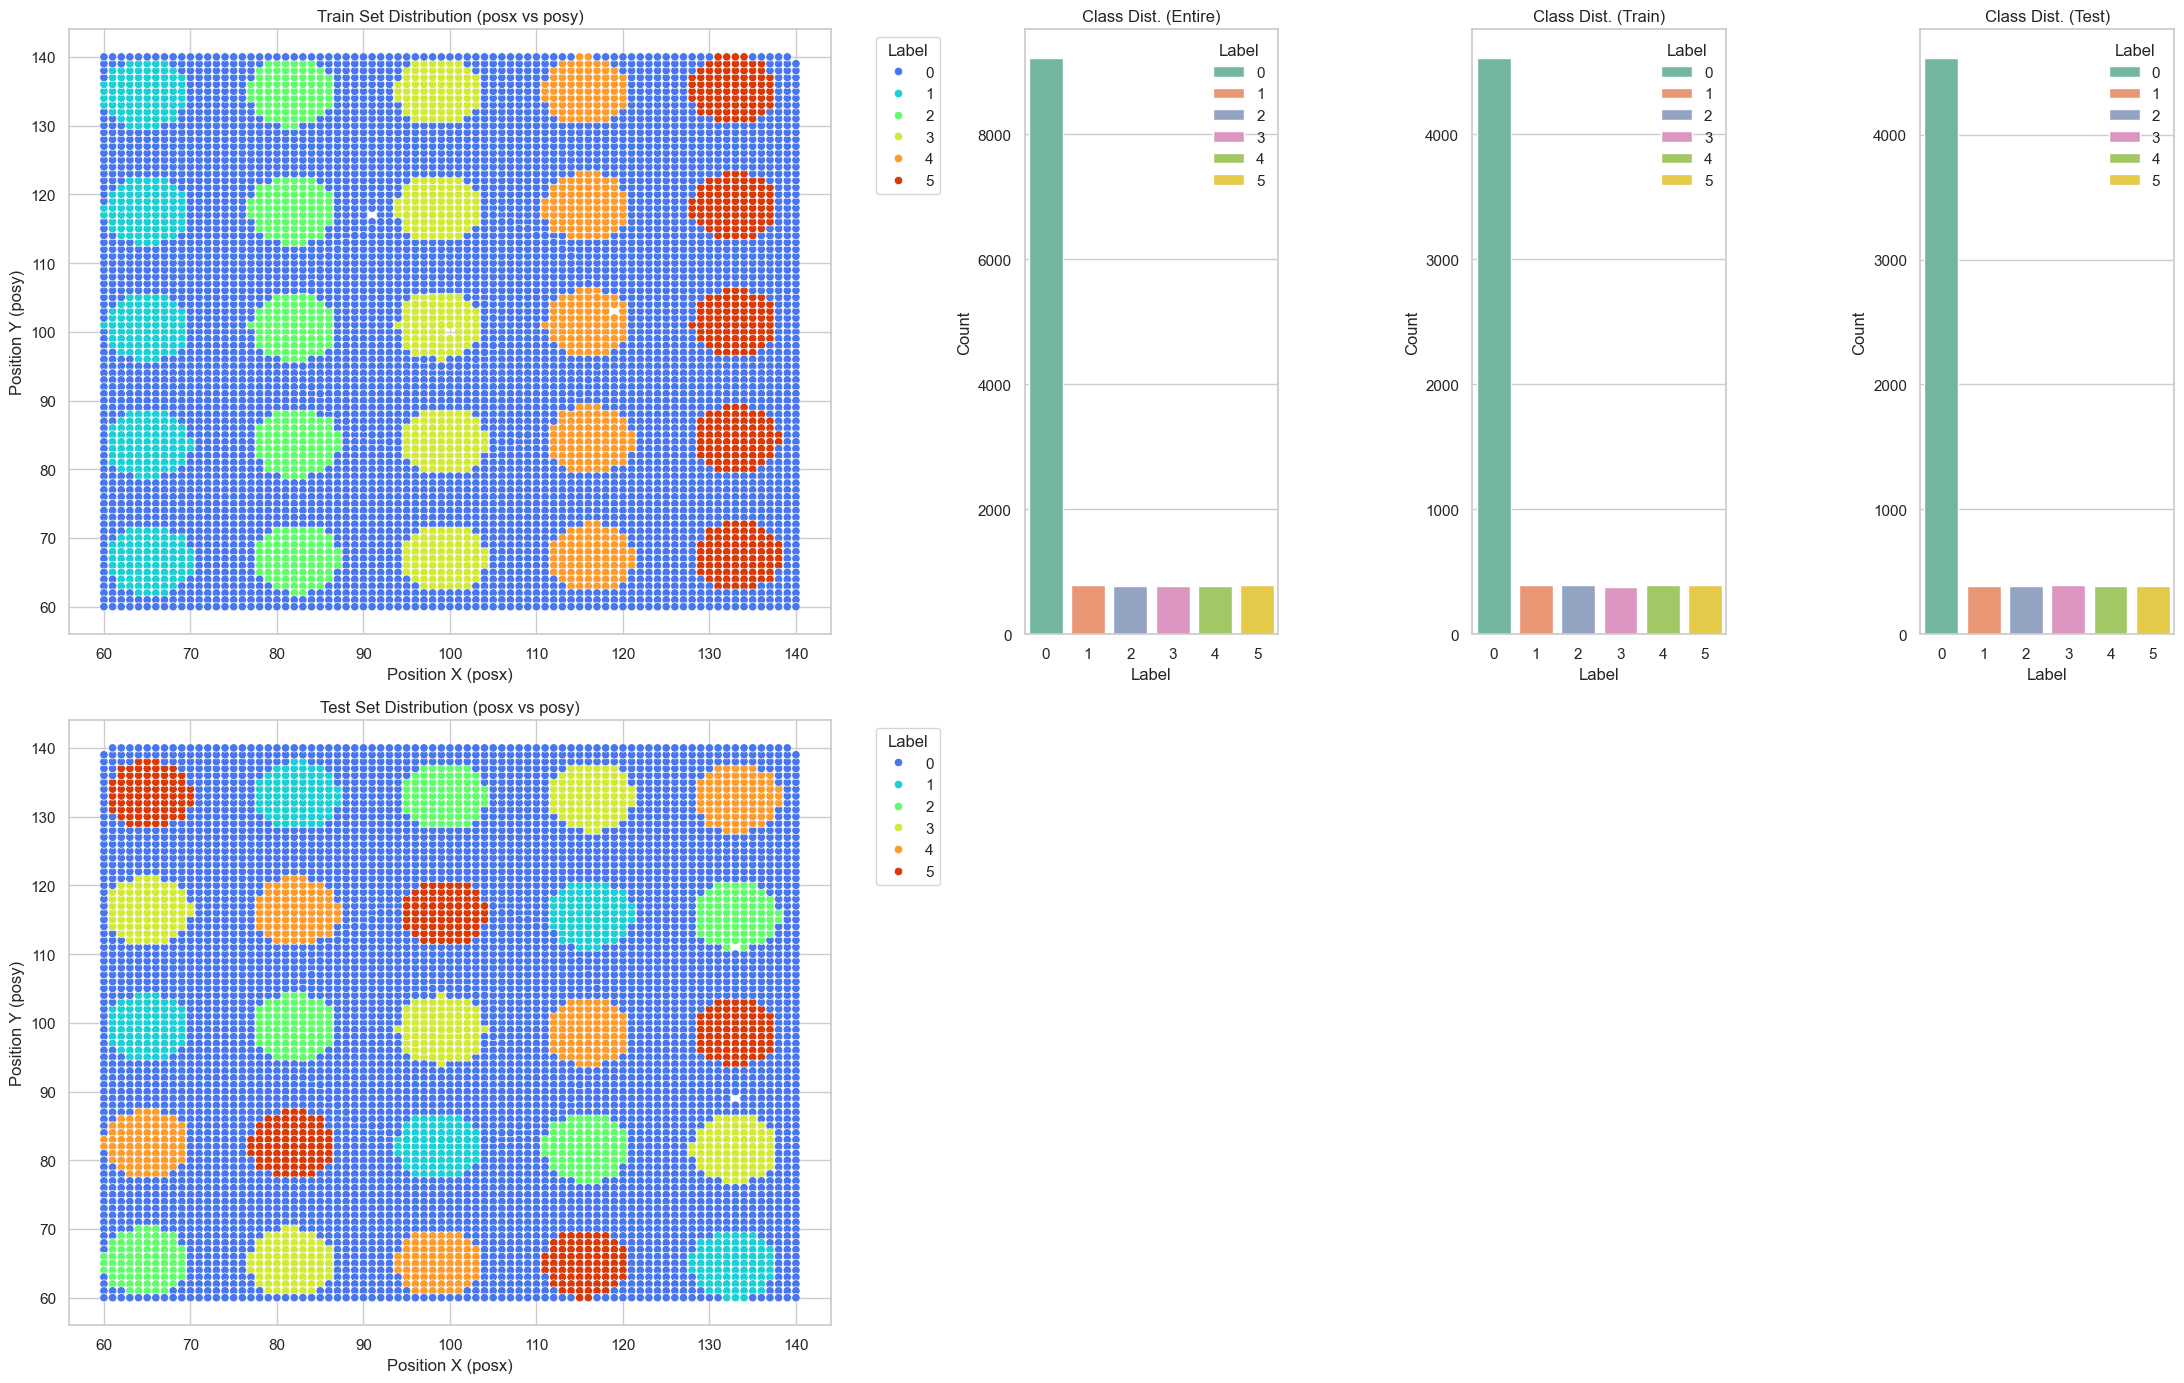

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import ADASYN
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Display class distribution
X = smoothed_df[feature_list + ["posx", "posy"]]
y = smoothed_df['label']

# train_df = pd.concat([train_df1, train_df2], ignore_index=True)
# smoothed_train = pd.concat([smoothed_train1, smoothed_train2], ignore_index=True)

# Training distribution:
class_distribution = Counter(smoothed_train['label'])
print("Class distribution in the dataset:")
for label, count in sorted(class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y) * 100:.2f}%)")

# Test distribution:
class_distribution = Counter(smoothed_test['label'])
print("Class distribution in the dataset:")
for label, count in sorted(class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y) * 100:.2f}%)")

# Prepare data for classification
X_train = smoothed_train[feature_list + ["posx", "posy"]]
y_train = smoothed_train['label']

X_test = smoothed_test[feature_list + ["posx", "posy"]]
y_test = smoothed_test['label']

# Preprocess data  -  No need a scaler in Random FOREST!!!!, if other model, apply after the splitting
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_train_scaled = X_train
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_list + ["posx", "posy"], index=X.index)
# X_test_scaled = X_test
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_list + ["posx", "posy"], index=X.index)


# Create the figure and axes: 2 rows (train/test), then 3 histograms
fig, axs = plt.subplots(2, 4, figsize=(22, 14), gridspec_kw={'width_ratios': [3, 1, 1, 1]})

# Set style
sns.set(style="whitegrid")

# Create consistent color map using turbo
unique_labels = sorted(data_train['label'].unique())  # or union of train + test if needed
palette_colors = sns.color_palette("turbo", n_colors=len(unique_labels))
label_color_dict = {label: color for label, color in zip(unique_labels, palette_colors)}

# Plot train
sns.scatterplot(
    data=data_train,
    x='posx',
    y='posy',
    hue='label',
    palette=label_color_dict,  # Use fixed mapping
    ax=axs[0, 0]
)
axs[0, 0].set_title("Train Set Distribution (posx vs posy)")
axs[0, 0].set_xlabel("Position X (posx)")
axs[0, 0].set_ylabel("Position Y (posy)")
axs[0, 0].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot test with same label-color mapping
sns.scatterplot(
    data=data_test,
    x='posx',
    y='posy',
    hue='label',
    palette=label_color_dict,  # Same dictionary ensures color consistency
    ax=axs[1, 0]
)
axs[1, 0].set_title("Test Set Distribution (posx vs posy)")
axs[1, 0].set_xlabel("Position X (posx)")
axs[1, 0].set_ylabel("Position Y (posy)")
axs[1, 0].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Histograms / Class Distribution Plots ---
plot_class_distribution(smoothed_df['label'], axs[0, 1], "Class Dist. (Entire)")
plot_class_distribution(y_train, axs[0, 2], "Class Dist. (Train)")
plot_class_distribution(y_test, axs[0, 3], "Class Dist. (Test)")

# Hide the unused bottom row histograms
for ax in axs[1, 1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# # Drop posx and posy columns from the training and testing sets after plotting
# X_train = X_train.drop(columns=['posx', 'posy'])
# X_test = X_test.drop(columns=['posx', 'posy'])

### Binary Classifier

In [35]:
from sklearn.preprocessing import StandardScaler

scaler_train1 = StandardScaler()
scaler_train2 = StandardScaler()
scaler_test = StandardScaler()

X_train_selected = X_train[feature_list]
X_test_selected = X_test[feature_list]

# X_train_selected_1 = X_train_selected[X_train["posy"] <= 140]
# X_train_selected_2 = X_train_selected[X_train["posy"] > 140]

X_train_scaled = scaler_train1.fit_transform(X_train_selected)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_list, index=X_train_selected.index)

# X_validation_scaled = scaler_train1.fit_transform(X_validation_selected)
# X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=feature_list, index=X_validation_selected.index)

# X_train_scaled2 = scaler_train2.fit_transform(X_train_selected_2)

# X_train_scaled1 = pd.DataFrame(X_train_scaled1, columns=feature_list, index=X_train_selected_1.index)
# X_train_scaled2 = pd.DataFrame(X_train_scaled2, columns=feature_list, index=X_train_selected_2.index)
# X_train_scaled = pd.concat([X_train_scaled1, X_train_scaled2]).sort_index()

X_test_scaled = scaler_test.fit_transform(X_test_selected)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_list, index=X_test_selected.index)


Class distribution after ADASYN:
Label 0: 4608 samples (49.59%)
Label 1: 4684 samples (50.41%)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      4613
           1       0.72      0.91      0.80      1944

    accuracy                           0.87      6557
   macro avg       0.84      0.88      0.85      6557
weighted avg       0.88      0.87      0.87      6557


Train Accuracy: 0.942, Train Balanced Accuracy: 0.941
Test Accuracy: 0.866, Test Balanced Accuracy: 0.878


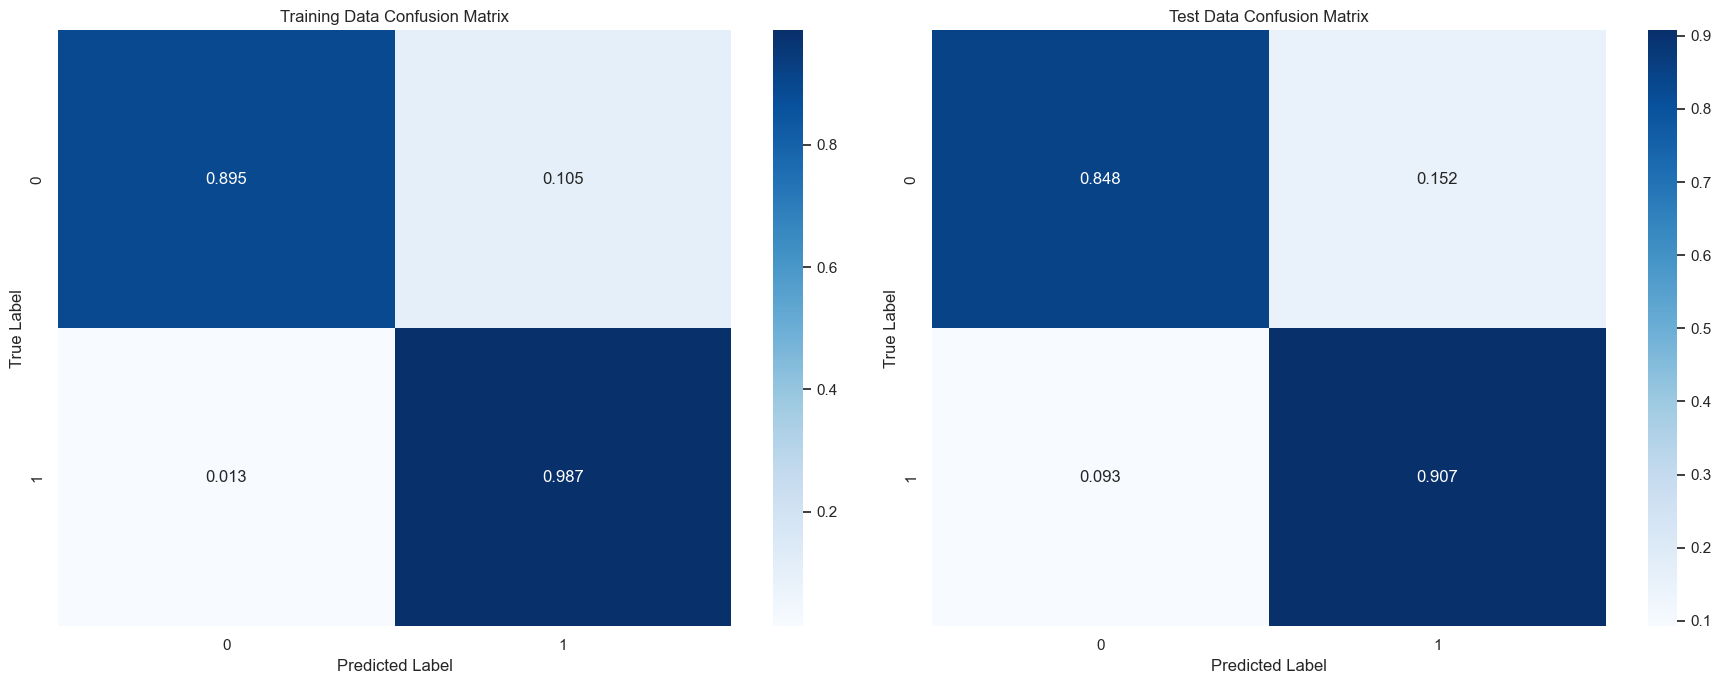

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Create dataset with selected features (excluding posx, posy)
# X_train_selected = X_train[feature_list]
# X_test_selected = X_test[feature_list]

X_train_selected = X_train_scaled
X_test_selected = X_test_scaled

# Convert labels to binary classification (0 vs all)
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

# Apply ADASYN for class imbalance handling
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train_binary)
# X_train_adasyn, y_train_multi = X_train_selected, y_train

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model on binary data
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred = rf_model.predict(X_test_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_binary, y_test_pred, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test_binary, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_binary, y_test_pred)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)

print(f"\nTrain Accuracy: {train_accuracy:.3f}, Train Balanced Accuracy: {train_balanced_acc:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}, Test Balanced Accuracy: {test_balanced_acc:.3f}")


# Function to create and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0

    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')


# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test_binary, y_test_pred, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()


In [37]:
from plotter import plot_features

X_test_new = X_test
# Xa = X_train_selected.copy()
# Xa["label"] = y_train_binary
# Xa["posx"] = X_train["posx"]
# Xa["posy"] = X_train["posy"]
#
# Xb = X_test_selected.copy()
# Xb["label"] = y_test_binary
# Xb["posx"] = X_test["posx"]
# Xb["posy"] = X_test["posy"]
#
# X_new_test = Xb.copy()
# X_new_test["label"] = y_test
#
# X_new_train = Xa.copy()
# X_new_train["label"] = y_train
#
# plot_features(Xa, Xb, feature_list)

In [38]:
hard_spots_test_index = y_test_pred == 1
hard_spots_test = X_test[hard_spots_test_index]
y_test_hard = y_test[hard_spots_test_index]

# y_train_pred = rf_model.predict(X_train[feature_list])
hard_spots_train_index = y_train != 0
hard_spots_train = X_train[hard_spots_train_index]
y_train_hard = y_train[hard_spots_train_index]

print(X_train.shape)
hard_spots_train.shape

(6558, 6)


(1950, 6)

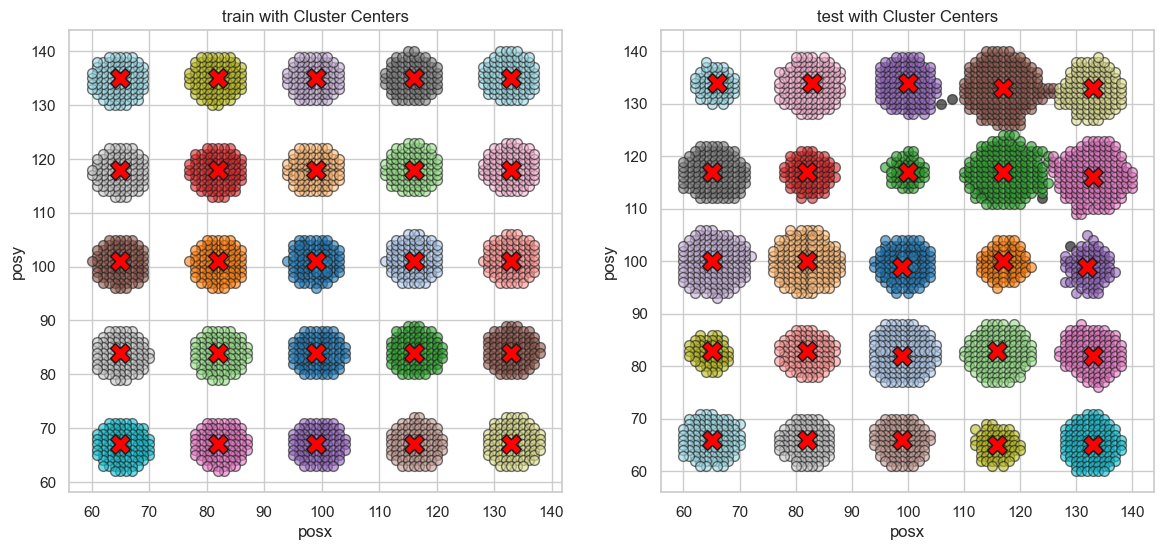

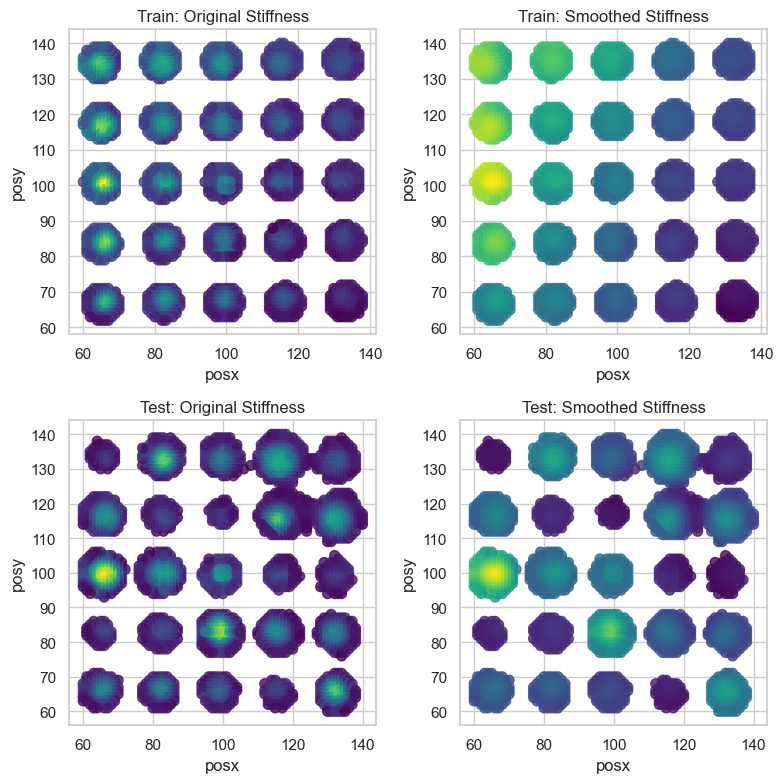

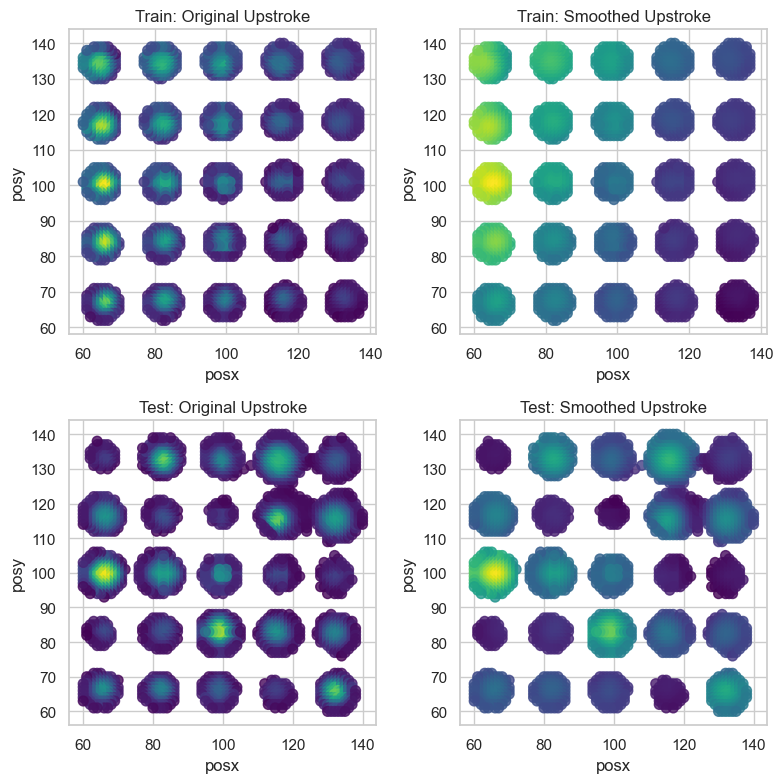

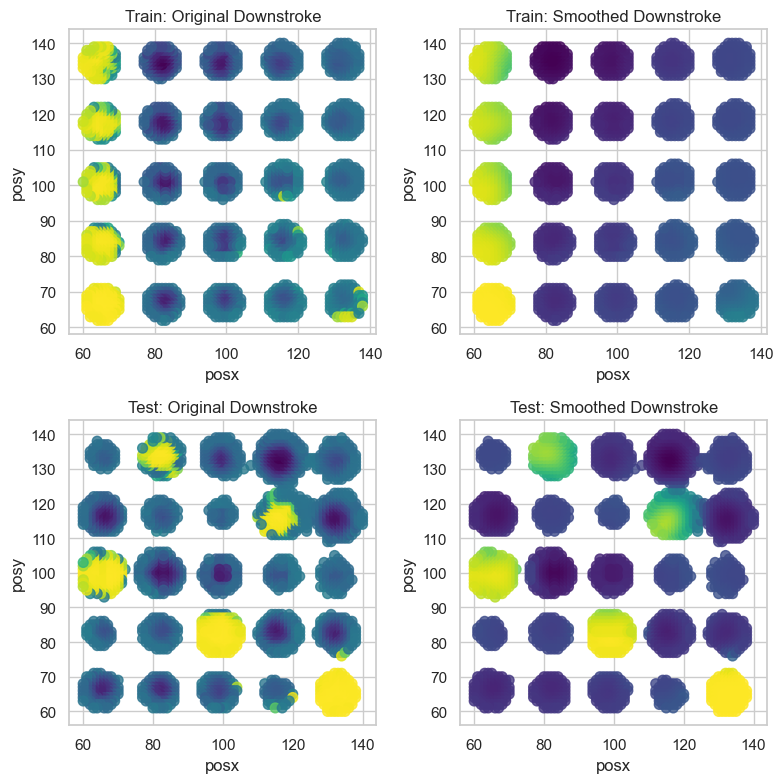

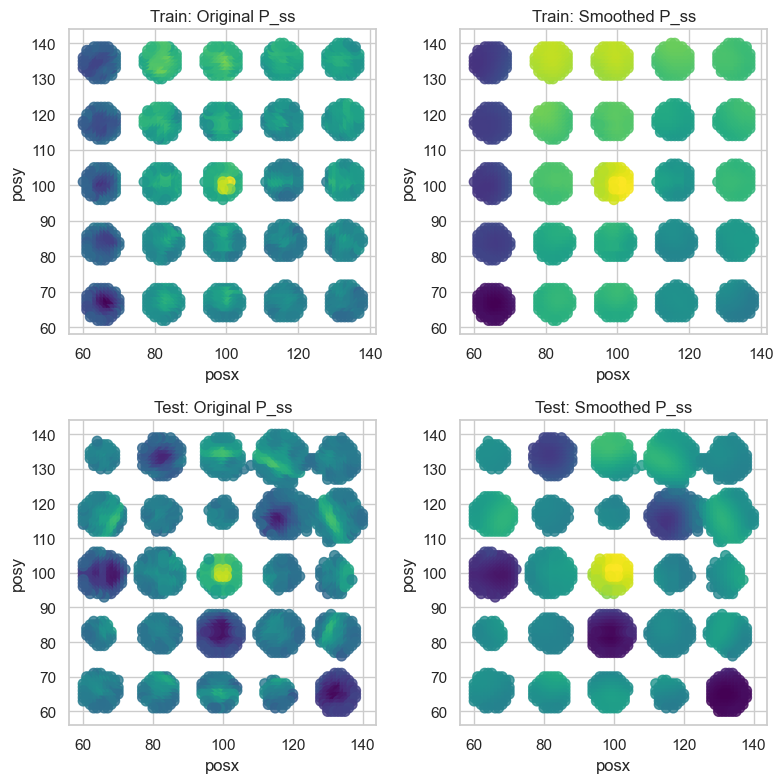

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN


def reverse_weighted_smooth(df, features_to_smooth, bandwidth=4.0, center_emphasis=3.0):
    # Create a copy of the dataframe to store smoothed values
    df_smoothed = df.copy()

    # Extract spatial coordinates
    coords = df[['posx', 'posy']].values

    # Use DBSCAN to identify clusters
    clustering = DBSCAN(eps=2.0, min_samples=10).fit(coords)
    labels = clustering.labels_

    # Find cluster centers
    centers = []
    center_indices = []

    for label in np.unique(labels):
        if label == -1:  # Skip noise points
            continue

        # Get points in this cluster
        cluster_mask = labels == label
        cluster_points = coords[cluster_mask]

        # Calculate centroid
        centroid = np.mean(cluster_points, axis=0)
        centers.append(centroid)

        # Find the point closest to the centroid
        distances_to_centroid = np.sum((cluster_points - centroid) ** 2, axis=1)
        closest_point_idx = np.where(cluster_mask)[0][np.argmin(distances_to_centroid)]
        center_indices.append(closest_point_idx)

    # Apply smoothing to each feature
    for feature in features_to_smooth:
        if feature in df.columns and feature not in ['posx', 'posy', 'label']:
            # Get feature values as array
            feature_values = df[feature].values.copy()
            original_values = feature_values.copy()

            # For each point, calculate weighted average based on distance
            for i in range(len(coords)):
                # Calculate distances to all other points
                dists = np.sqrt(np.sum((coords - coords[i]) ** 2, axis=1))

                # Create weights with Gaussian kernel
                kernel_weights = np.exp(-0.5 * (dists / bandwidth) ** 2)

                # Determine if this point is a center
                is_center = i in center_indices

                if is_center:
                    # For center points, preserve their original value or even emphasize it
                    central_value = original_values[i]
                    # Blend with weighted average, but give more weight to the original center value
                    avg_value = np.sum(kernel_weights * original_values) / np.sum(kernel_weights)
                    feature_values[i] = (central_value * center_emphasis + avg_value) / (center_emphasis + 1)
                else:
                    # Regular smoothing for non-center points
                    feature_values[i] = np.sum(kernel_weights * original_values) / np.sum(kernel_weights)

            # Update the smoothed dataframe
            df_smoothed[feature] = feature_values

    return df_smoothed, centers, center_indices, labels


def visualize_clusters_and_centers(df, center_indices, labels, ax, title):
    # Create a colormap for clusters
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    # Plot points colored by cluster
    for i, label in enumerate(unique_labels):
        if label == -1:
            # Black for noise points
            cluster_color = 'black'
        else:
            cluster_color = colors[i]

        mask = labels == label
        ax.scatter(df.loc[mask, 'posx'], df.loc[mask, 'posy'],
                   c=[cluster_color], edgecolor='k', s=50,
                   alpha=0.6)

    # Plot centers with X markers
    center_points = df.iloc[center_indices][['posx', 'posy']].values
    ax.scatter(center_points[:, 0], center_points[:, 1],
               c='red', marker='X', s=200, edgecolor='k')

    ax.set_title(f'{title} with Cluster Centers')
    ax.set_xlabel('posx')
    ax.set_ylabel('posy')


features_to_smooth = [f for f in feature_list if f not in ['posx', 'posy']]
hard_spots_test_smoothed, centers, center_indices, labels = reverse_weighted_smooth(
    hard_spots_test, features_to_smooth, bandwidth=3.0, center_emphasis=0.00001)

hard_spots_train_smoothed, centers2, center_indices2, labels2 = reverse_weighted_smooth(
    hard_spots_train, features_to_smooth, bandwidth=3.0, center_emphasis=0.00001)

# Visualize the clusters and centers7
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
visualize_clusters_and_centers(hard_spots_test, center_indices, labels, axes[1], "test")
visualize_clusters_and_centers(hard_spots_train, center_indices2, labels2, axes[0], "train")


# Plot the smoothing effect for comparison
def plot_smoothing_effect(test_original, test_smooth, train_original, train_smoothed, feature):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    # Plot original values
    sc1 = axes[1][0].scatter(test_original['posx'], test_original['posy'],
                             c=test_original[feature], cmap='viridis',
                             s=50, alpha=0.8)
    axes[1][0].set_title(f"Test: Original {feature}")
    axes[1][0].set_xlabel("posx")
    axes[1][0].set_ylabel("posy")

    sc1 = axes[0][0].scatter(train_original['posx'], train_original['posy'],
                             c=train_original[feature], cmap='viridis',
                             s=50, alpha=0.8)
    axes[0][0].set_title(f"Train: Original {feature}")
    axes[0][0].set_xlabel("posx")
    axes[0][0].set_ylabel("posy")

    # Plot smoothed values
    sc2 = axes[1][1].scatter(test_smooth['posx'], test_smooth['posy'],
                             c=test_smooth[feature], cmap='viridis',
                             s=50, alpha=0.8)
    axes[1][1].set_title(f"Test: Smoothed {feature}")
    axes[1][1].set_xlabel("posx")
    axes[1][1].set_ylabel("posy")

    sc2 = axes[0][1].scatter(train_smoothed['posx'], train_smoothed['posy'],
                             c=train_smoothed[feature], cmap='viridis',
                             s=50, alpha=0.8)
    axes[0][1].set_title(f"Train: Smoothed {feature}")
    axes[0][1].set_xlabel("posx")
    axes[0][1].set_ylabel("posy")

    plt.tight_layout()
    plt.show()


for feature in features_to_smooth:
    plot_smoothing_effect(hard_spots_test, hard_spots_test_smoothed, hard_spots_train, hard_spots_train_smoothed,
                          feature)

### Full Classifier


Class distribution after ADASYN:
Label 1: 395 samples (20.26%)
Label 2: 391 samples (20.05%)
Label 3: 378 samples (19.38%)
Label 4: 390 samples (20.00%)
Label 5: 396 samples (20.31%)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       700
           1       0.69      0.99      0.81       388
           2       0.54      0.54      0.54       385
           3       0.39      0.70      0.50       385
           4       0.37      0.63      0.47       322
           5       0.52      0.53      0.53       284

    accuracy                           0.49      2464
   macro avg       0.42      0.56      0.47      2464
weighted avg       0.36      0.49      0.41      2464



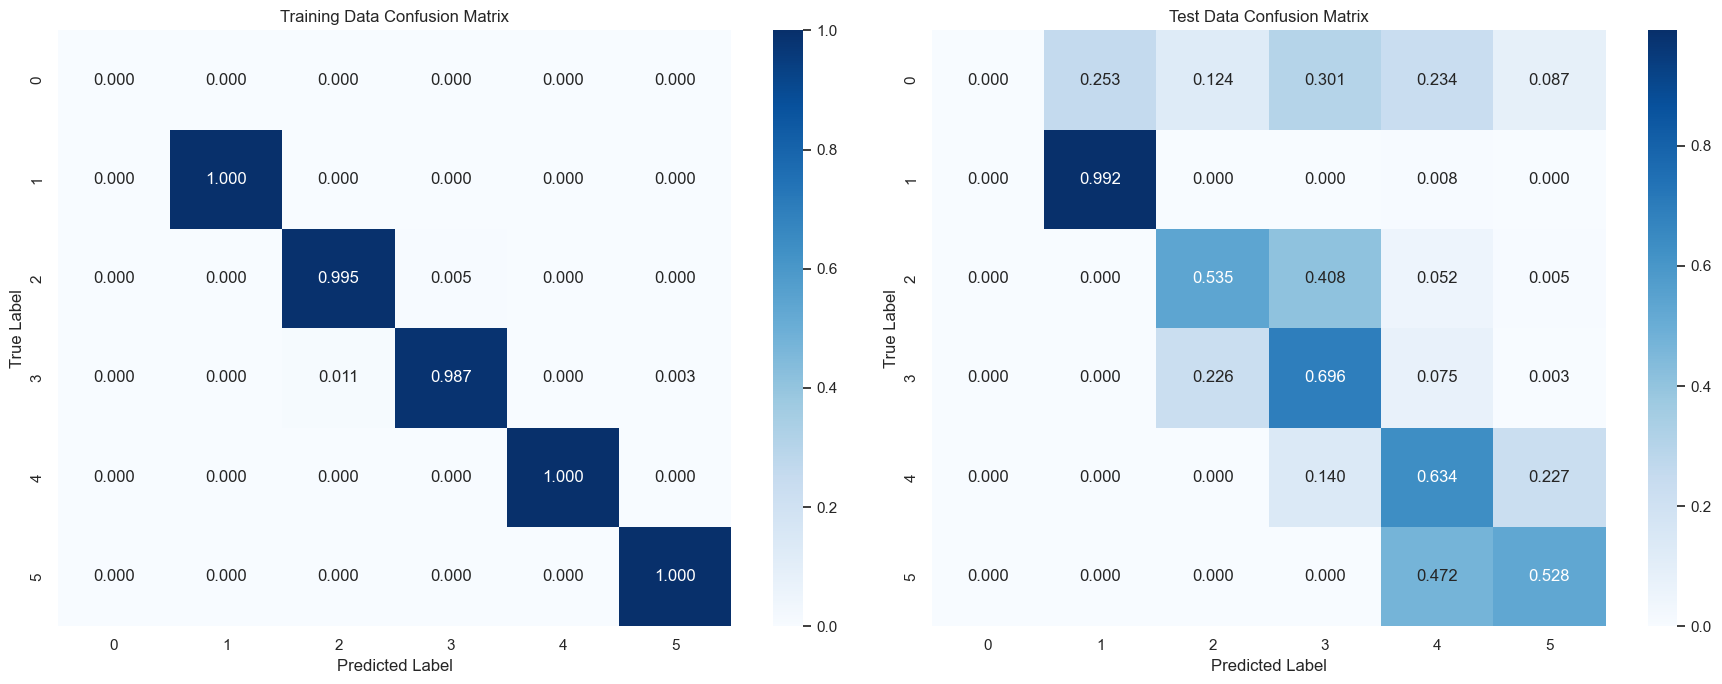

In [40]:
from plotter import plot_confusion_matrix

# test_index = y_test_pred == 1
# X_test_new_nz = X_test_new[test_index]
# y_test_nz = y_test[test_index]
#
# train_index = y_train != 0
# X_train_nz = X_train[train_index]
# y_train_nz = y_train[train_index]
#
# X_train_selected = X_train_nz[feature_list]
# X_test_selected = X_test_new_nz[feature_list]  #X_test  --- X_test_new

X_train_selected = hard_spots_train_smoothed[feature_list]
X_test_selected = hard_spots_test_smoothed[feature_list]
y_train_nz = y_train_hard
y_test_nz = y_test_hard

# Apply ADASYN for adaptive oversampling
# adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
# X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)

X_train_adasyn, y_train_adasyn = X_train_selected, y_train_nz

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred_nz = rf_model.predict(X_test_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_nz, y_test_pred_nz, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test_nz, y_test_pred_nz)
test_balanced_acc = balanced_accuracy_score(y_test_nz, y_test_pred_nz)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)

# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test_nz, y_test_pred_nz, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()


C:\Users\brill\AppData\Local\Temp\ipykernel_5240\1369572678.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_filtered = X_train_selected[train_mask]
C:\Users\brill\AppData\Local\Temp\ipykernel_5240\1369572678.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_filtered = X_test_selected[test_mask]


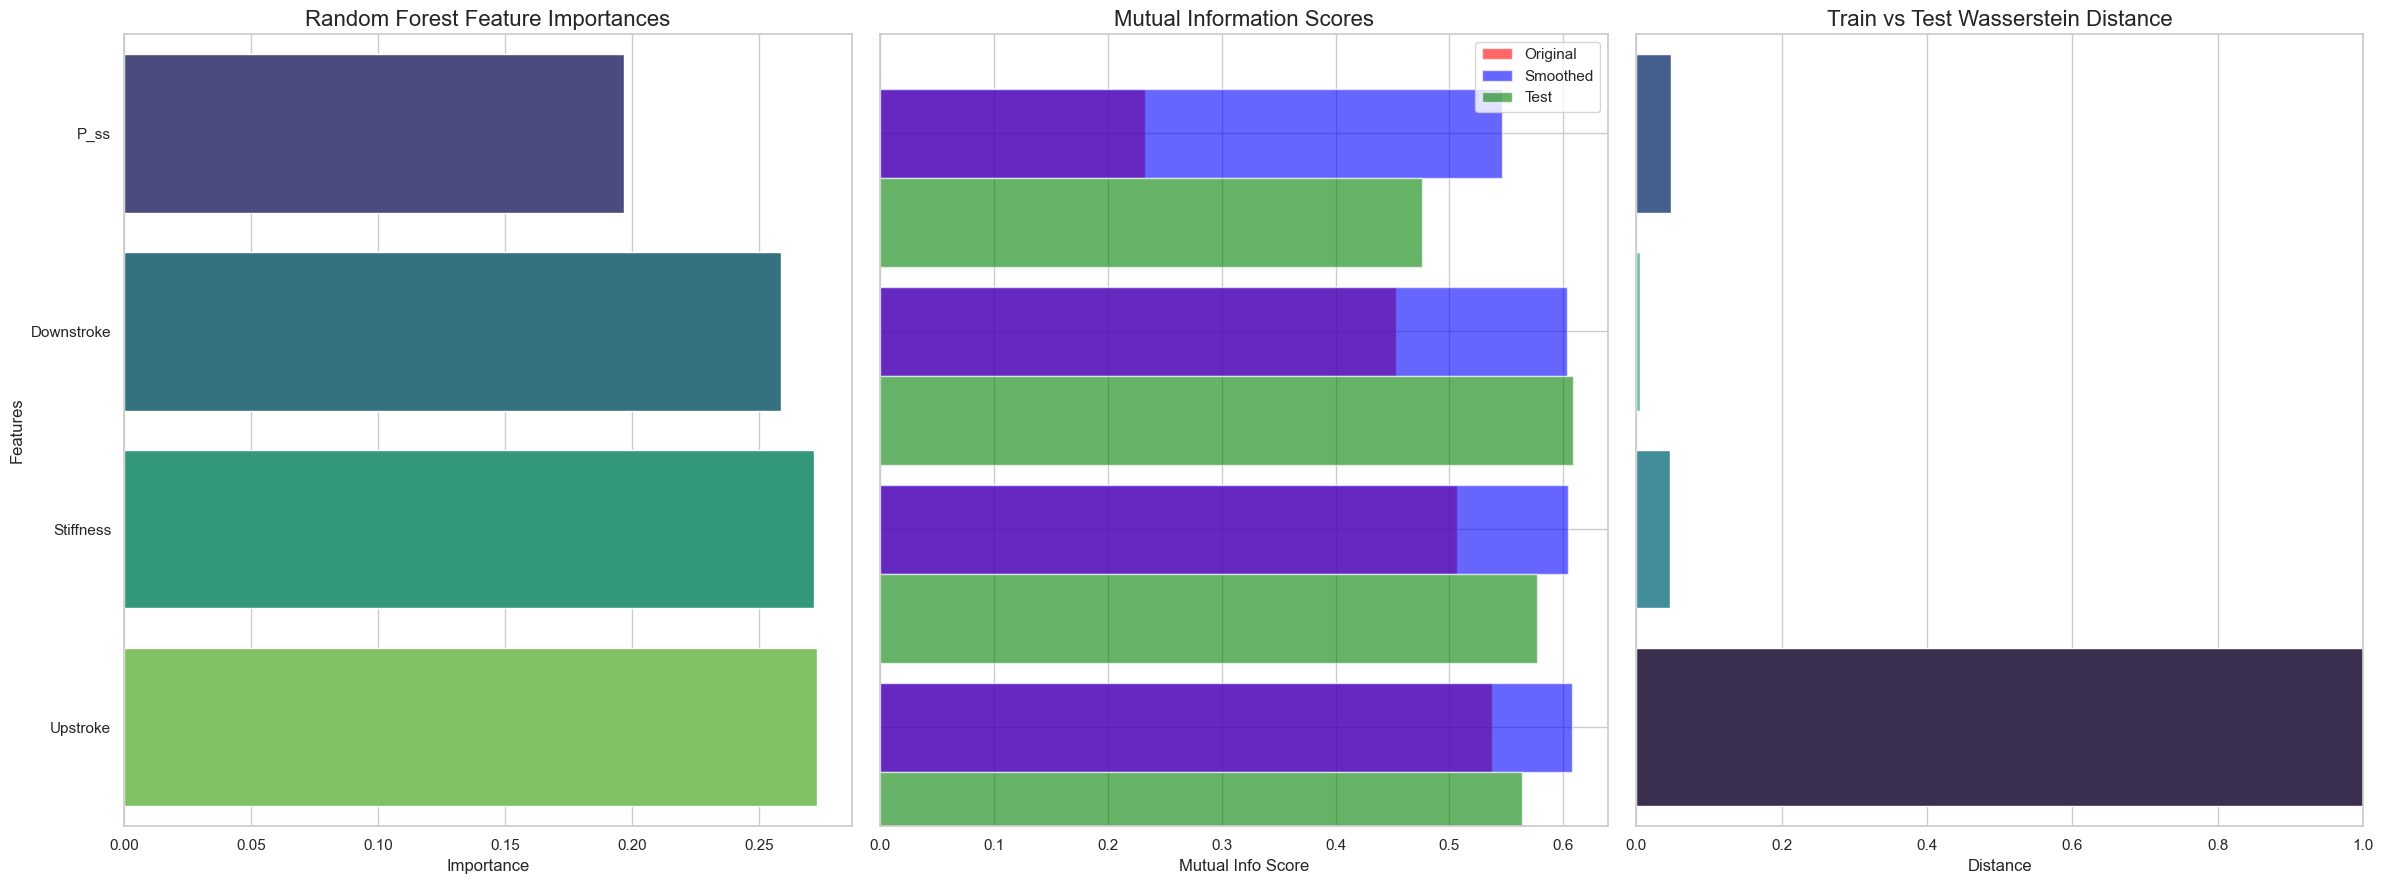

✅ Features with MI (smoothed train & test > 0.4) and Wasserstein < 0.05:
['P_ss', 'Downstroke', 'Upstroke']


In [41]:
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

# --- Random Forest Feature Importances ---

# Assuming rf_model is your trained model and top_features is your list of features

feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances and sort them
importance_df = pd.DataFrame({
    'feature': feature_list,
    'importance': feature_importances
}).sort_values('importance', ascending=True)

# --- Mutual Information Scores ---

X = data_train[feature_list]
y = data_train['label']

# Compute mutual information scores for each feature
mi_scores = mutual_info_classif(X, y, random_state=42)

X2 = smoothed_train[feature_list]
y2 = smoothed_train['label']

# Compute mutual information scores for each feature (smoothed)
mi_scores2 = mutual_info_classif(X2, y2, random_state=42)

# Create a DataFrame for mutual information scores and sort them

# --- Mutual Information on Test Set ---
X_test_mi = smoothed_test[feature_list]
y_test_mi = smoothed_test['label']
mi_scores_test = mutual_info_classif(X_test_mi, y_test_mi, random_state=42)

# Combine all MI scores
mi_df = pd.DataFrame({
    'feature': feature_list,
    'original': mi_scores,
    'smoothed': mi_scores2,
    'test': mi_scores_test,
}).sort_values('original', ascending=True)

# Select only label 3, 4, 5 from train and test
selected_labels = [3, 4, 5]
train_mask = y_train.isin(selected_labels)
test_mask = y_test.isin(selected_labels)

X_train_filtered = X_train_selected[train_mask]
X_test_filtered = X_test_selected[test_mask]

# --- Compute Wasserstein distance for each feature ---
distance_data = {
    'feature': [],
    'wasserstein_distance': []
}

for feat in feature_list:
    train_feat = X_train_filtered[feat]
    test_feat = X_test_filtered[feat]
    distance = wasserstein_distance(train_feat, test_feat)
    distance_data['feature'].append(feat)
    distance_data['wasserstein_distance'].append(distance)

# distance_df = pd.DataFrame(distance_data).sort_values('wasserstein_distance', ascending=True)
distance_df = pd.DataFrame(distance_data)

# 3 subplots: Importance | Mutual Info | Distance
fig, axes = plt.subplots(1, 3, figsize=(24, 9), sharey=True)

# 1. Random Forest Feature Importances
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis', ax=axes[0], hue="feature", legend=False)
axes[0].set_title('Random Forest Feature Importances', fontsize=16)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_ylabel('Features', fontsize=12)

# 2. Mutual Information: Original, Smoothed, Test
bar_width = 0.45
y_positions = np.arange(len(mi_df))
ax = axes[1]

ax.barh(y_positions, mi_df['original'], height=bar_width, color='red', alpha=0.6, label='Original')
ax.barh(y_positions, mi_df['smoothed'], height=bar_width, color='blue', alpha=0.6, label='Smoothed')
ax.barh(y_positions + bar_width, mi_df['test'], height=bar_width, color='green', alpha=0.6, label='Test')

ax.set_yticks(y_positions)
ax.set_yticklabels(mi_df['feature'])
ax.set_title('Mutual Information Scores', fontsize=16)
ax.set_xlabel('Mutual Info Score', fontsize=12)
ax.set_ylabel('')
ax.legend()

# 3. Train/Test Distribution Distance
sns.barplot(x='wasserstein_distance', y='feature', data=distance_df, palette='mako', ax=axes[2], hue='feature',
            legend=False)
axes[2].set_title('Train vs Test Wasserstein Distance', fontsize=16)
axes[2].set_xlabel('Distance', fontsize=12)
axes[2].set_ylabel('')
axes[2].set_xlim(0, 1)

plt.tight_layout()
plt.show()

# Combine everything into a single DataFrame for easy filtering
combined_df = mi_df.merge(distance_df, on='feature')

# Filter by the given conditions
selected_features = combined_df[
    # (combined_df['smoothed'] > 0.4) &
    # (combined_df['test'] > 0.4) &
    (combined_df['wasserstein_distance'] < 0.12)
]

# Output the feature names
print("✅ Features with MI (smoothed train & test > 0.4) and Wasserstein < 0.05:")
print(selected_features['feature'].tolist())

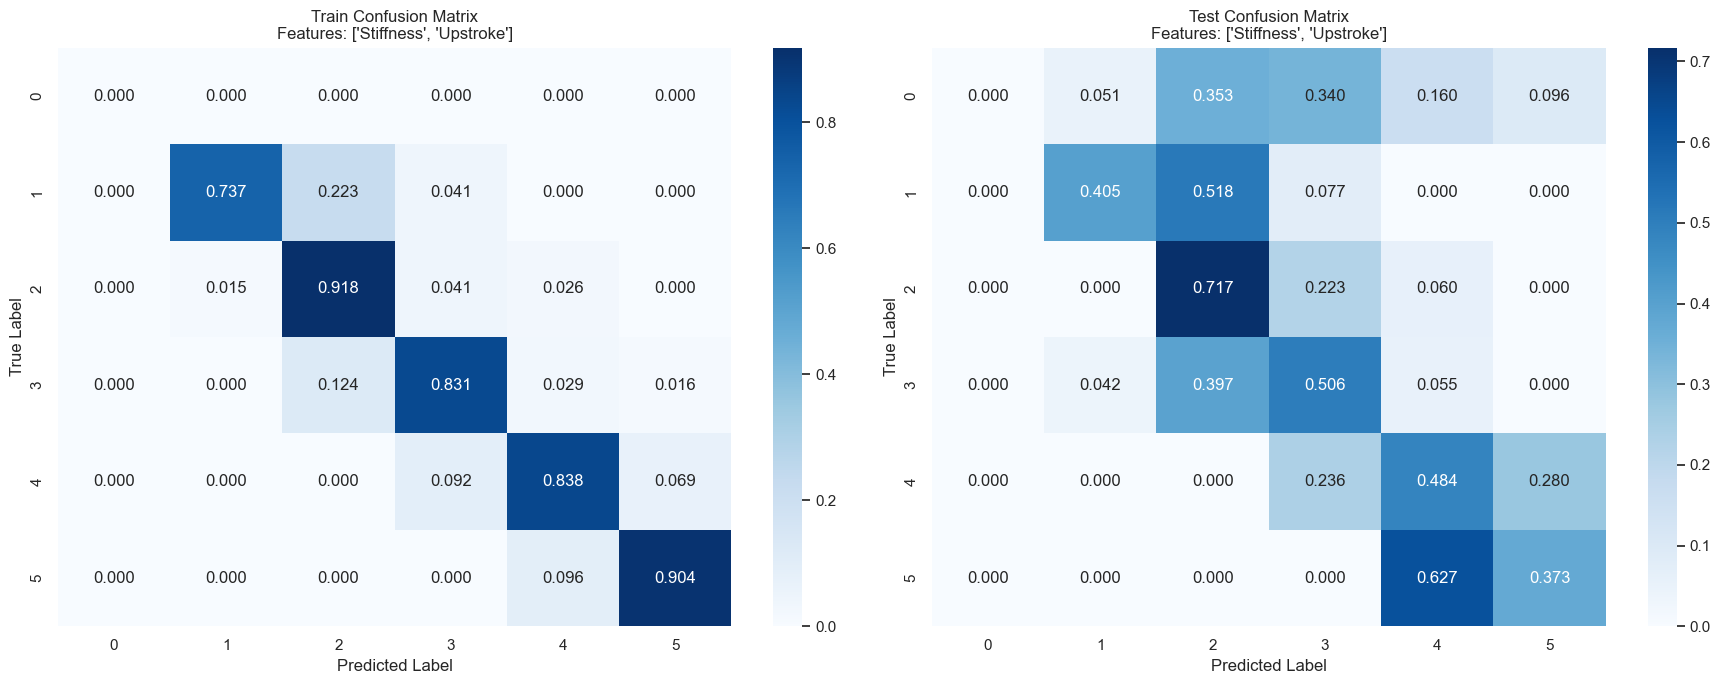

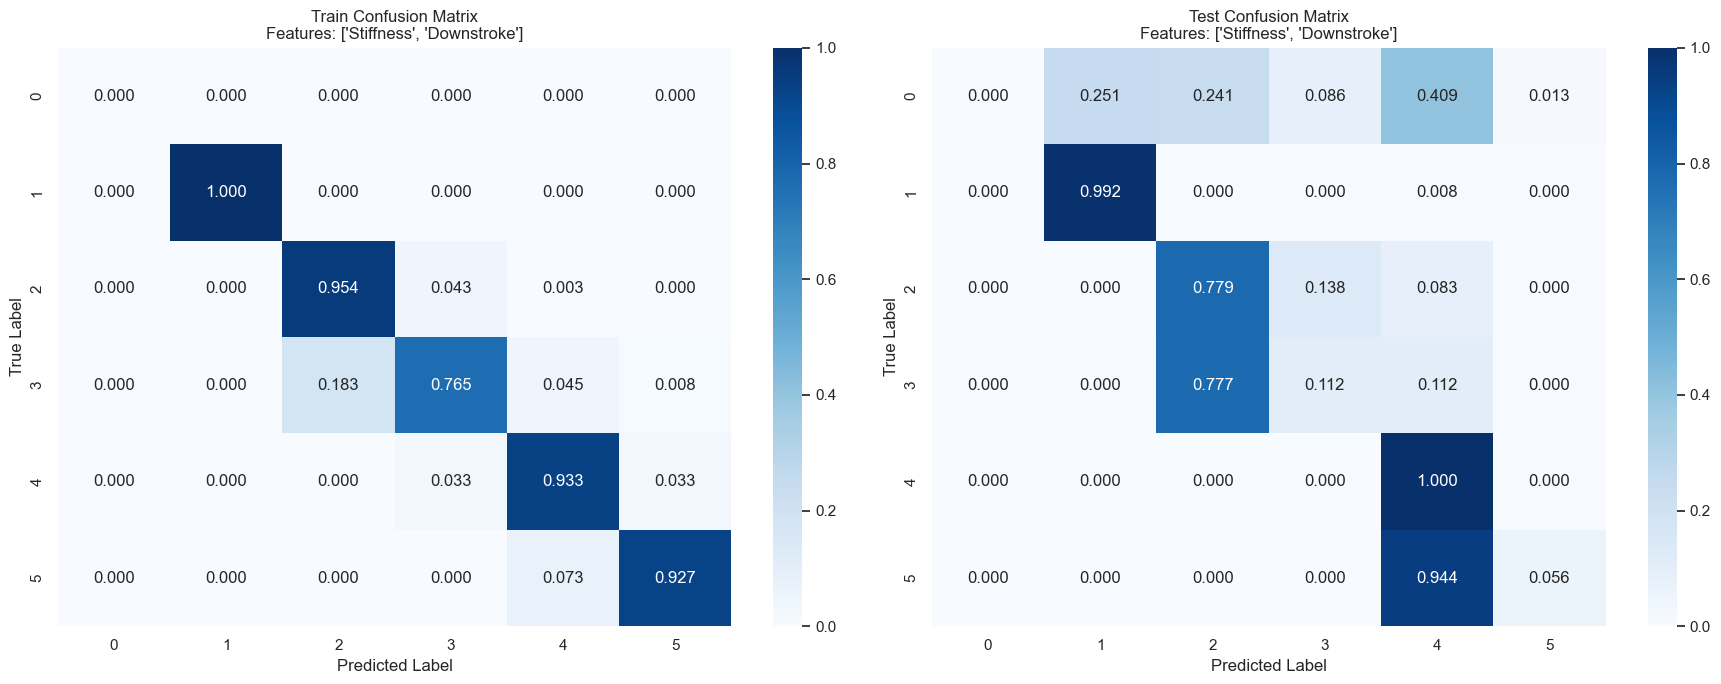

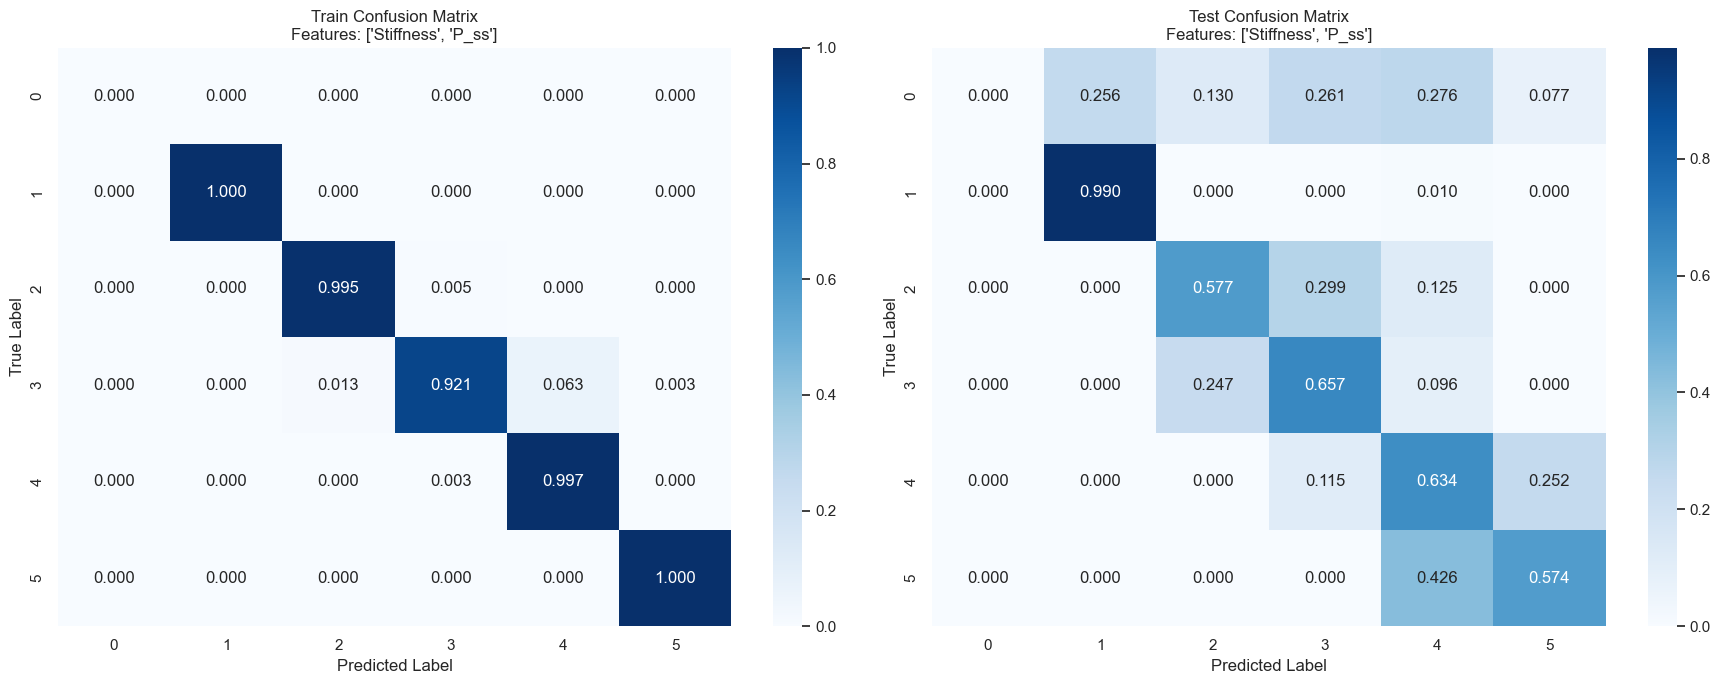

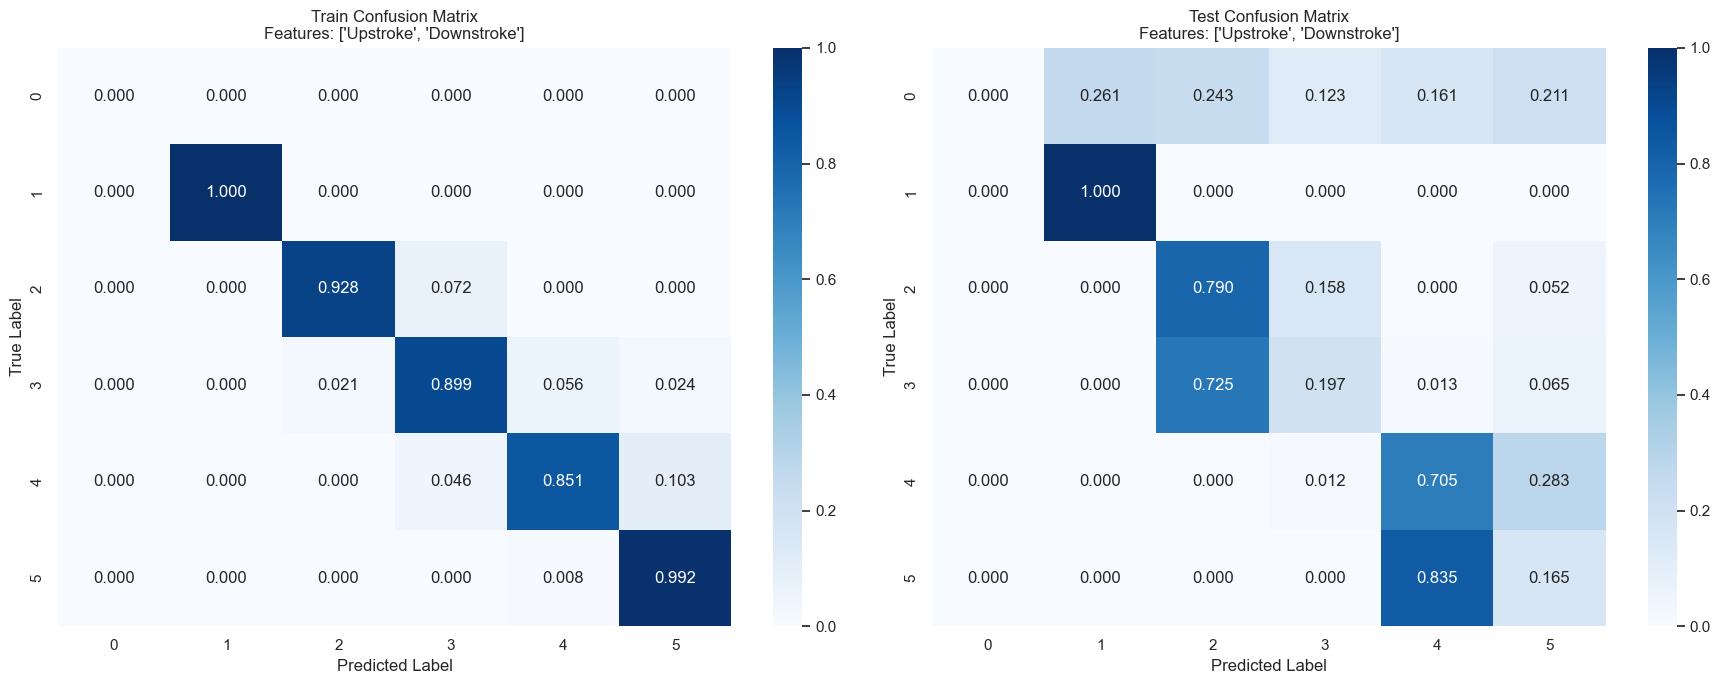

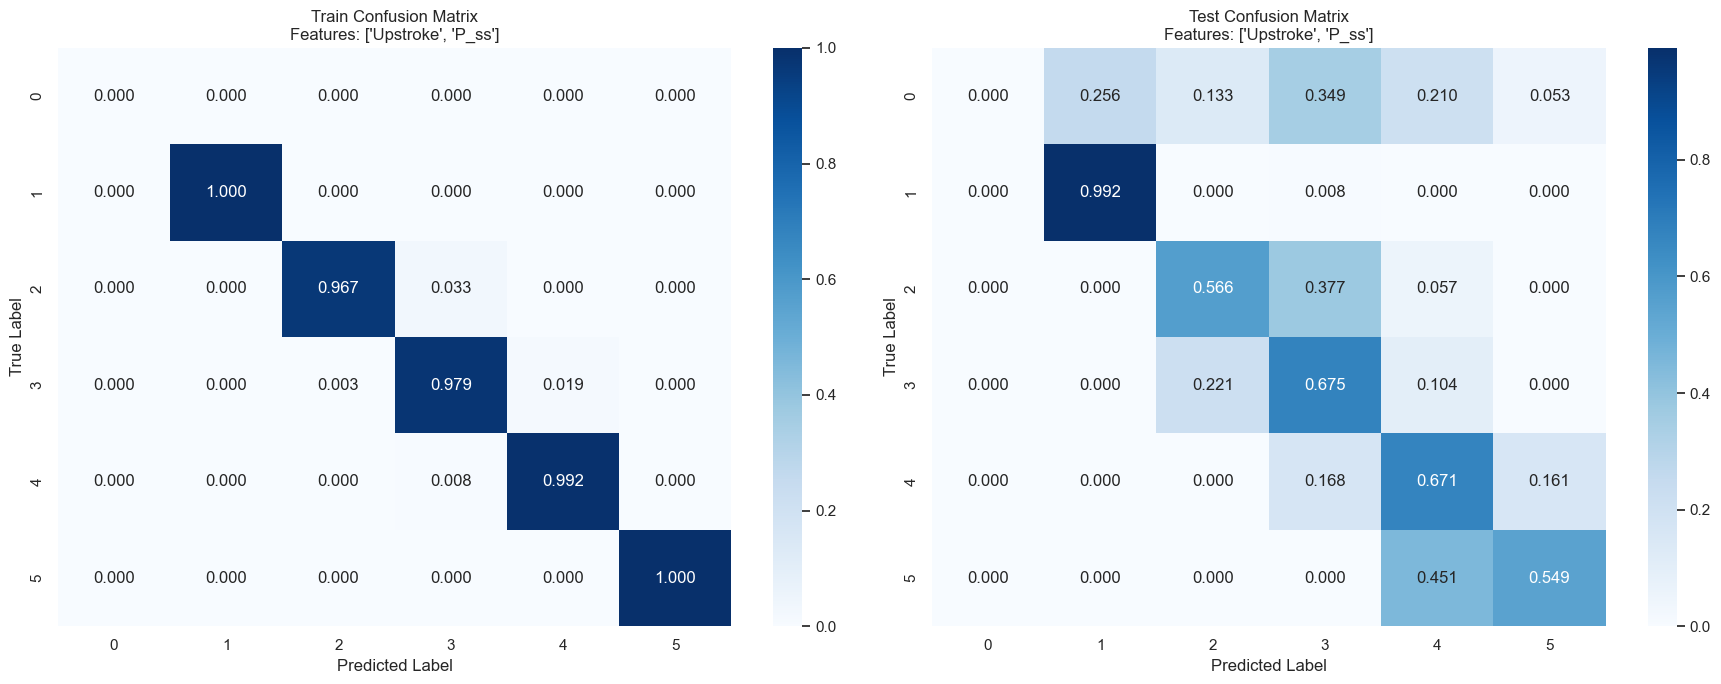

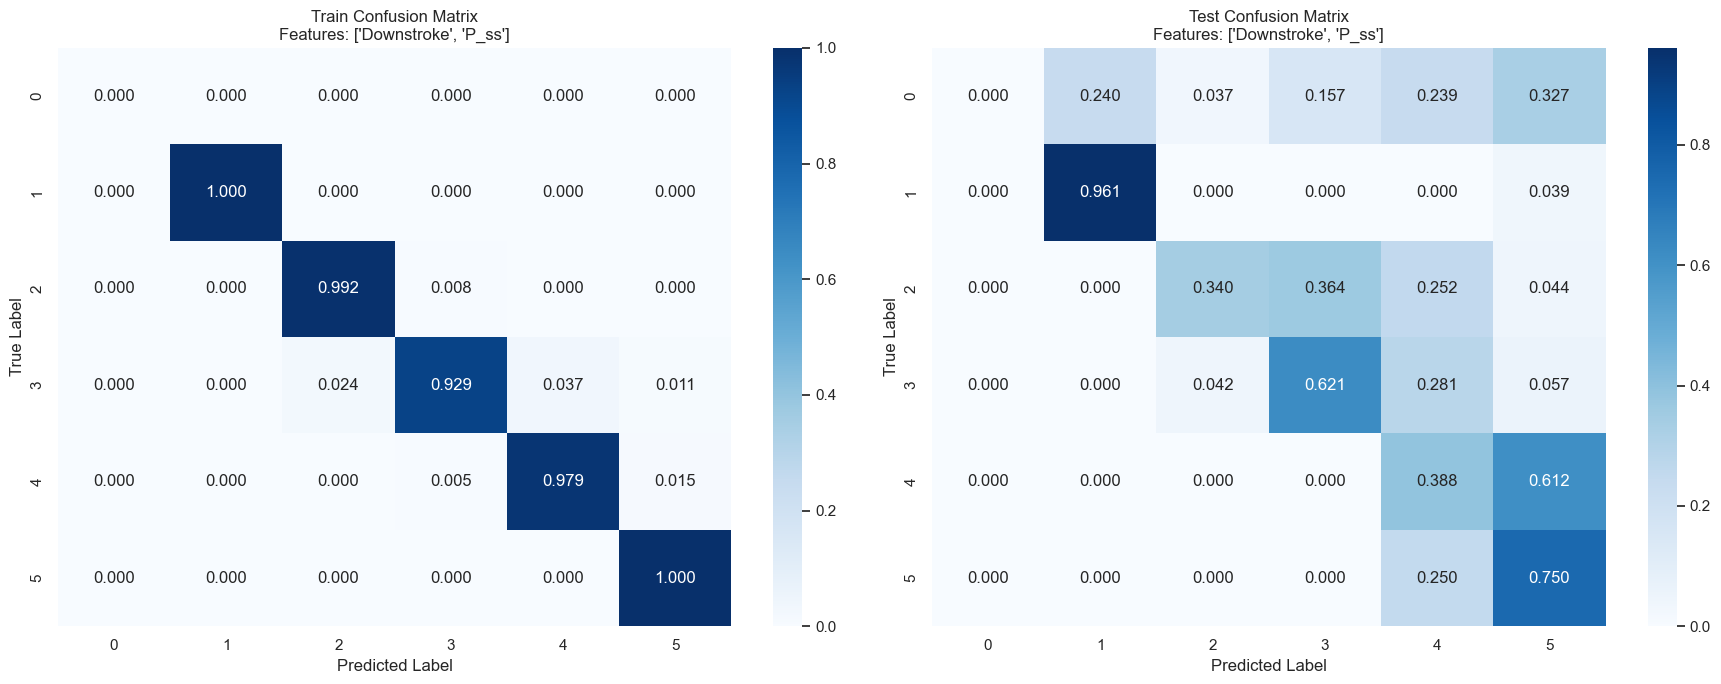

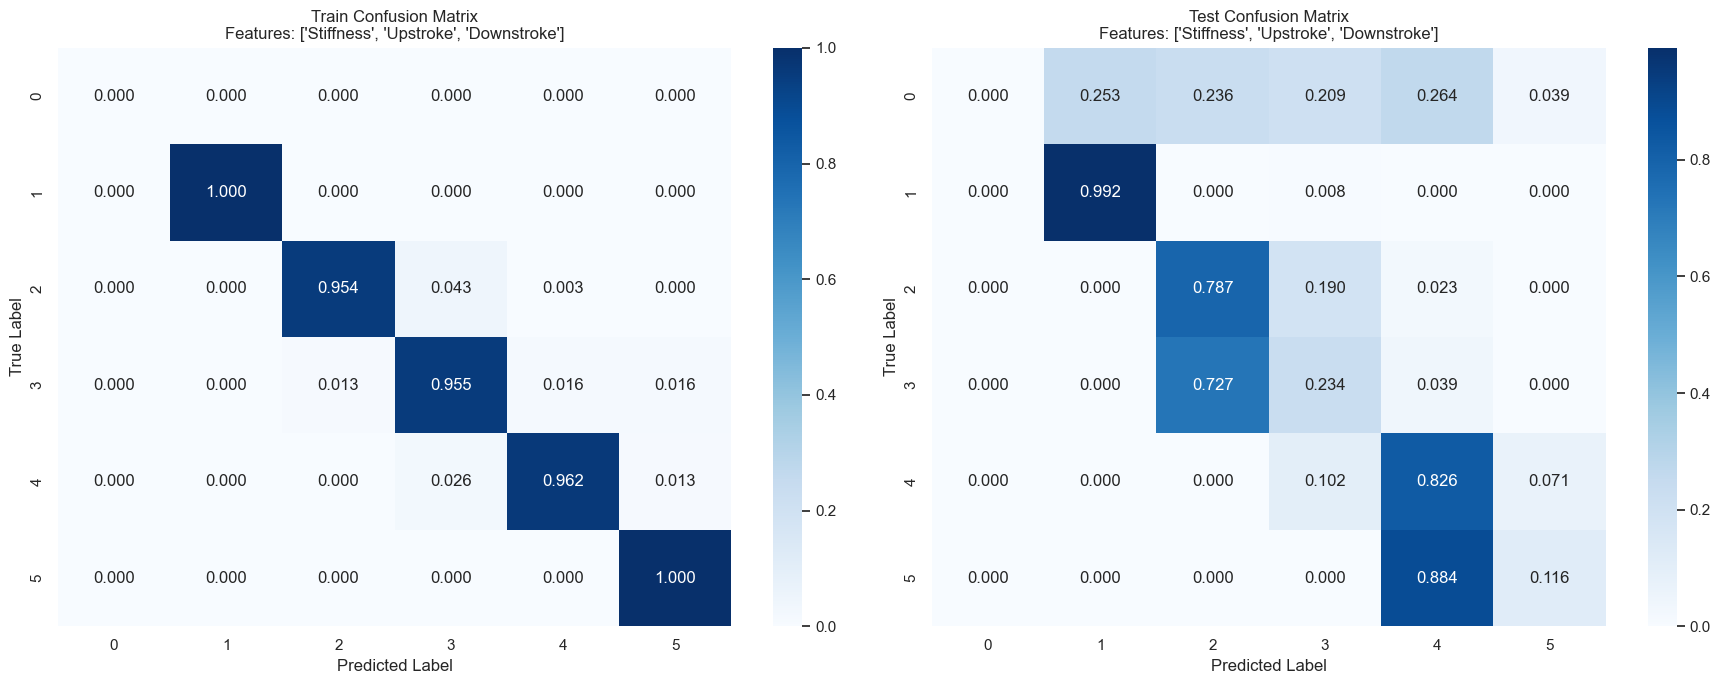

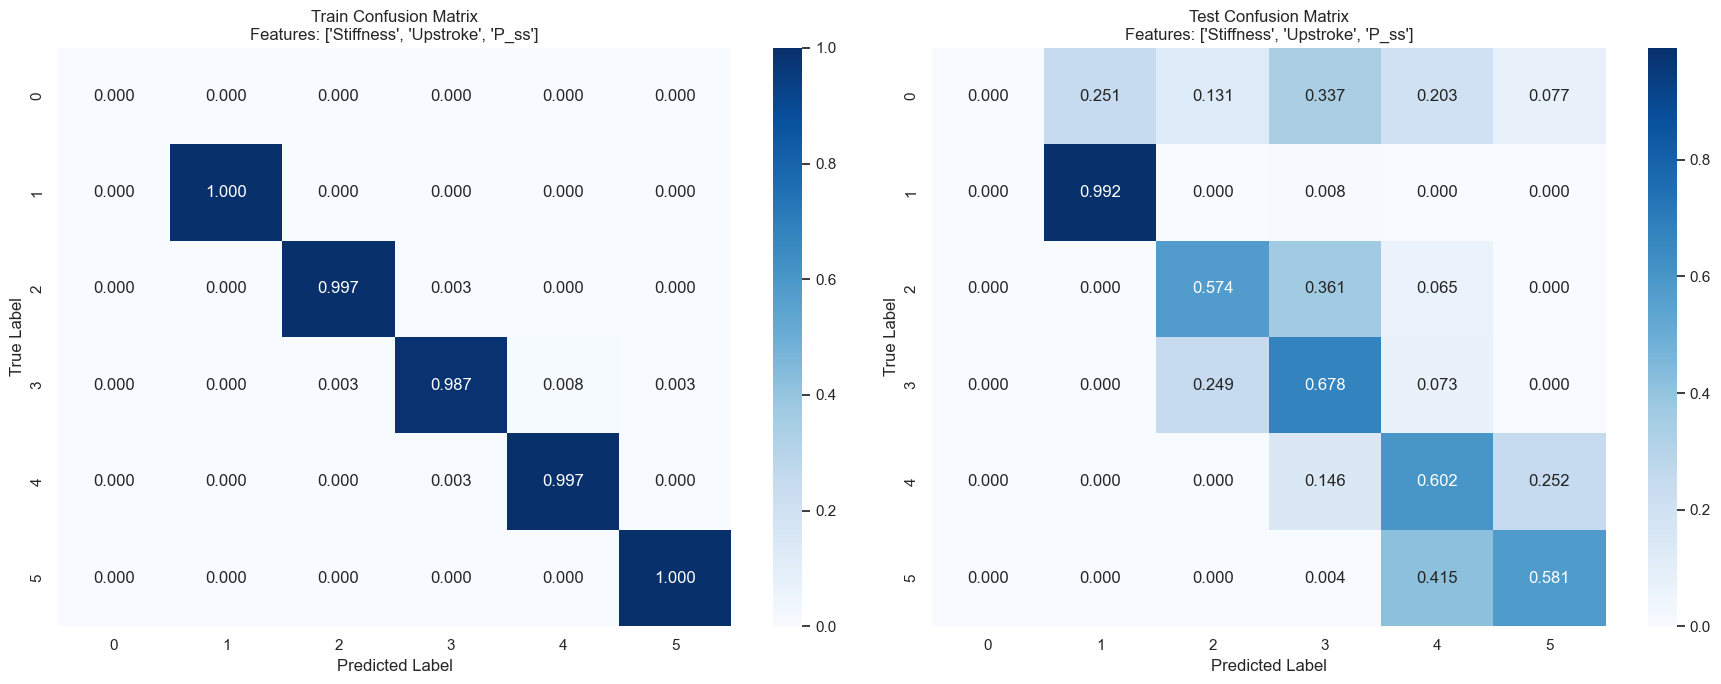

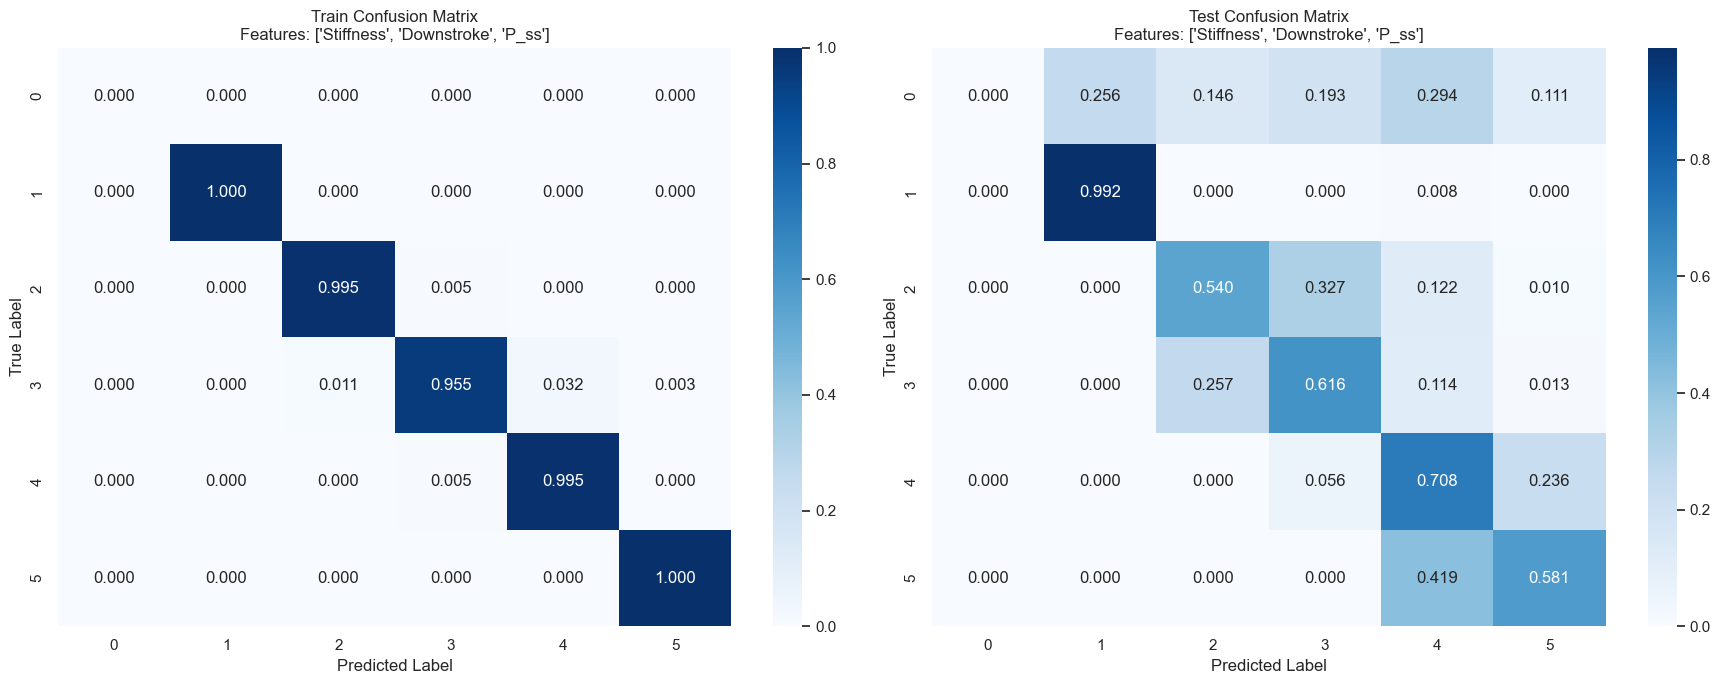

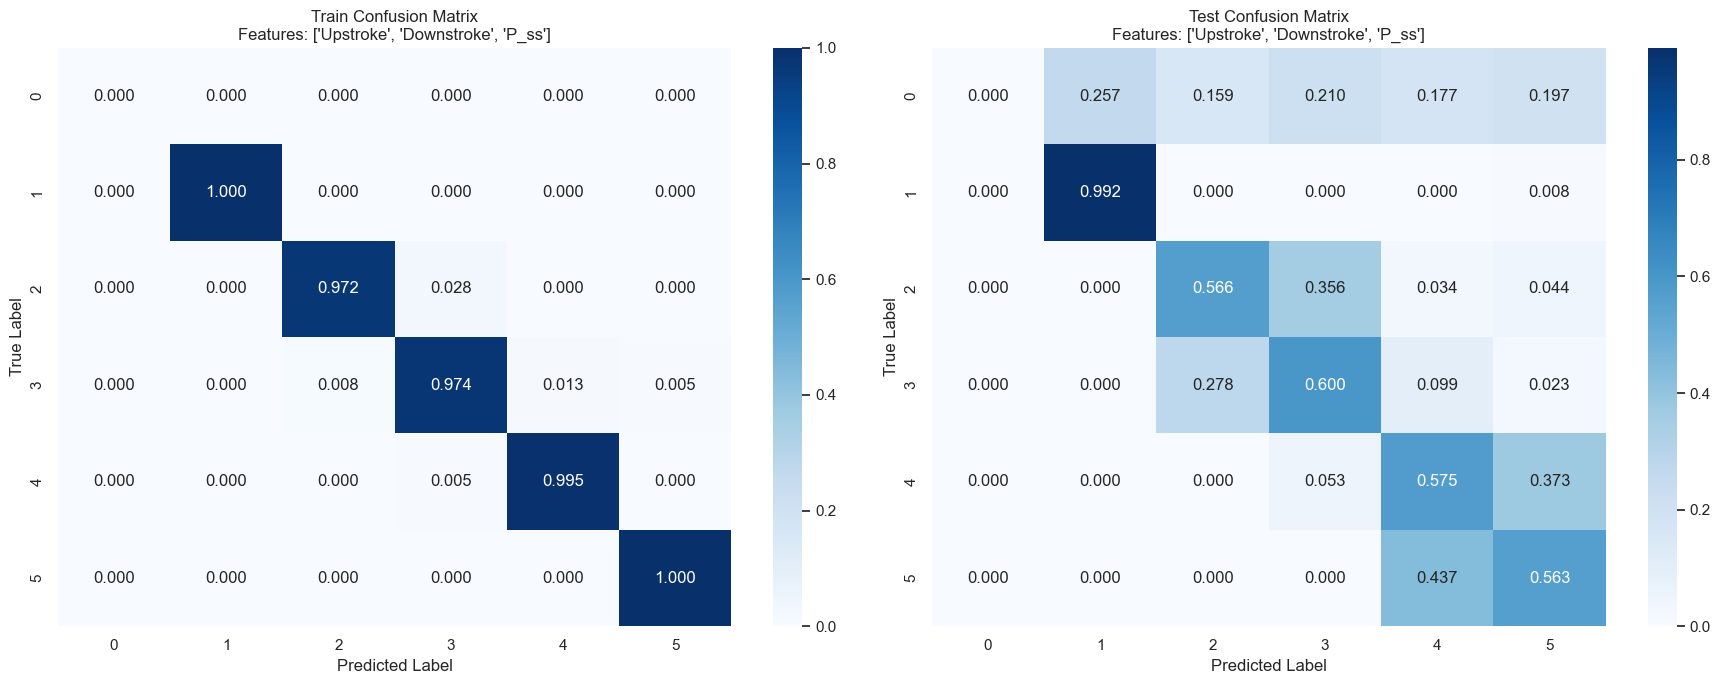

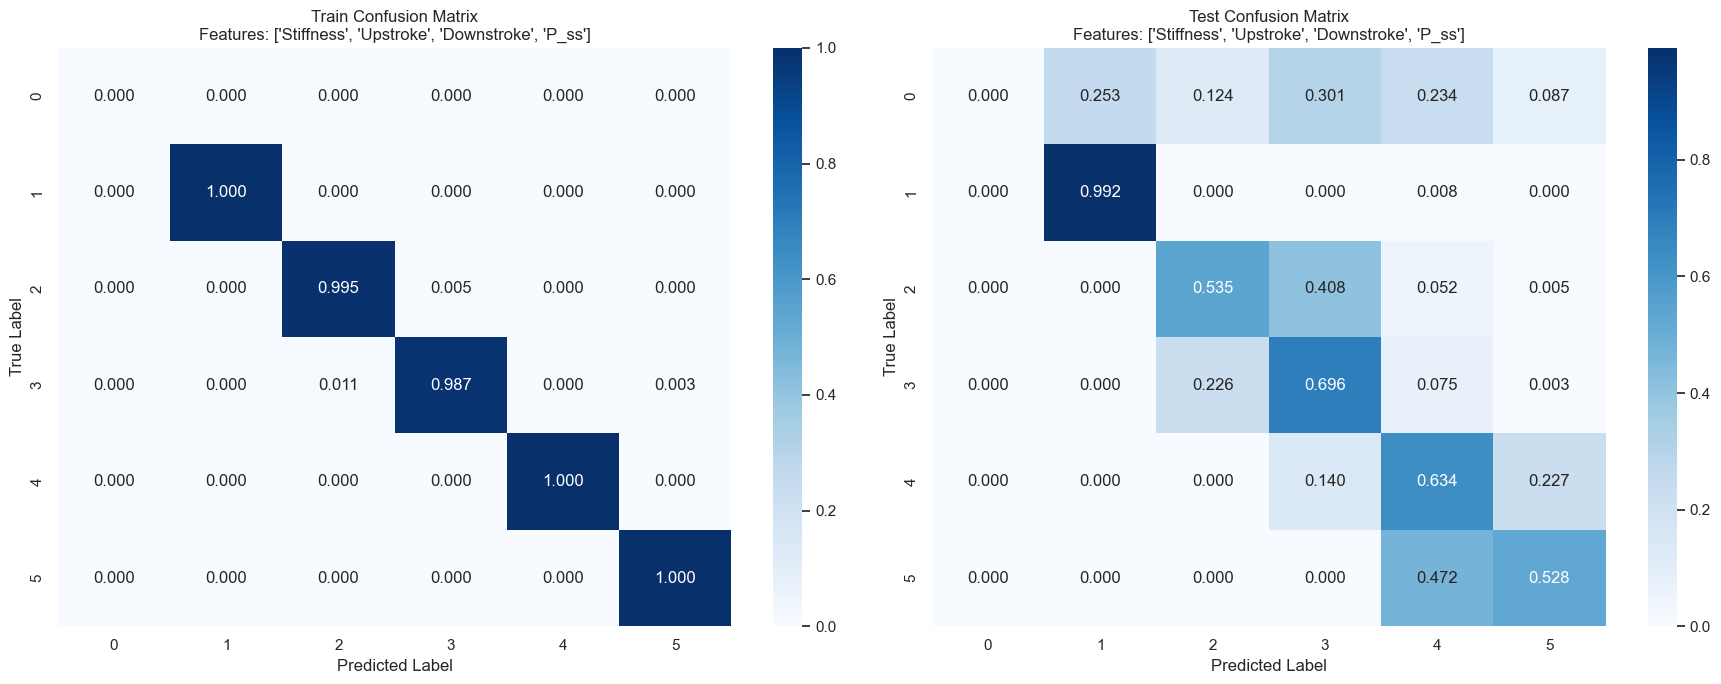

[(['Stiffness', 'Upstroke'], 0.3612012987012987, 0.4142878808239192),
 (['Stiffness', 'Downstroke'], 0.43262987012987014, 0.4899191933858697),
 (['Stiffness', 'P_ss'], 0.49756493506493504, 0.5718234983430595)]

In [42]:
# import itertools
# import matplotlib.pyplot as plt
# import pandas as pd
# from collections import Counter
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
#
#
# # Iterate through all combinations of 2 to 6 features
# results = []
# for r in range(2, len(feature_list) + 1):
#     for combo in itertools.combinations(feature_list, r):
#         selected_features = list(combo)
#
#         X_train_selected = hard_spots_train_smoothed[selected_features]
#         X_test_selected = hard_spots_test_smoothed[selected_features]
#         X_train_adasyn, y_train_adasyn = X_train_selected, y_train_nz
#
#         rf_model = RandomForestClassifier(
#             n_estimators=200,
#             max_depth=10,
#             min_samples_split=20,
#             min_samples_leaf=5,
#             bootstrap=True,
#             criterion='entropy',
#             class_weight=None,
#             random_state=42,
#             max_features=0.5,
#             n_jobs=-1,
#         )
#
#         rf_model.fit(X_train_adasyn, y_train_adasyn)
#         y_train_pred = rf_model.predict(X_train_adasyn)
#         y_test_pred_nz = rf_model.predict(X_test_selected)
#
#         train_acc = accuracy_score(y_train_adasyn, y_train_pred)
#         test_acc = accuracy_score(y_test_nz, y_test_pred_nz)
#         train_bal = balanced_accuracy_score(y_train_adasyn, y_train_pred)
#         test_bal = balanced_accuracy_score(y_test_nz, y_test_pred_nz)
#
#         results.append((selected_features, test_acc, test_bal))
#
#         # Plotting confusion matrices
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
#         plot_confusion_matrix(y_train_adasyn, y_train_pred, f"Train Confusion Matrix\nFeatures: {selected_features}", ax1)
#         plot_confusion_matrix(y_test_nz, y_test_pred_nz, f"Test Confusion Matrix\nFeatures: {selected_features}", ax2)
#         plt.tight_layout()
#         plt.show()
#
# results[:3]  # Show first 3 results for brevity


C:\Users\brill\AppData\Local\Temp\ipykernel_5240\3311844590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hard_spots_test["label"] = y_test_hard
C:\Users\brill\AppData\Local\Temp\ipykernel_5240\3311844590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hard_spots_train["label"] = y_train_hard


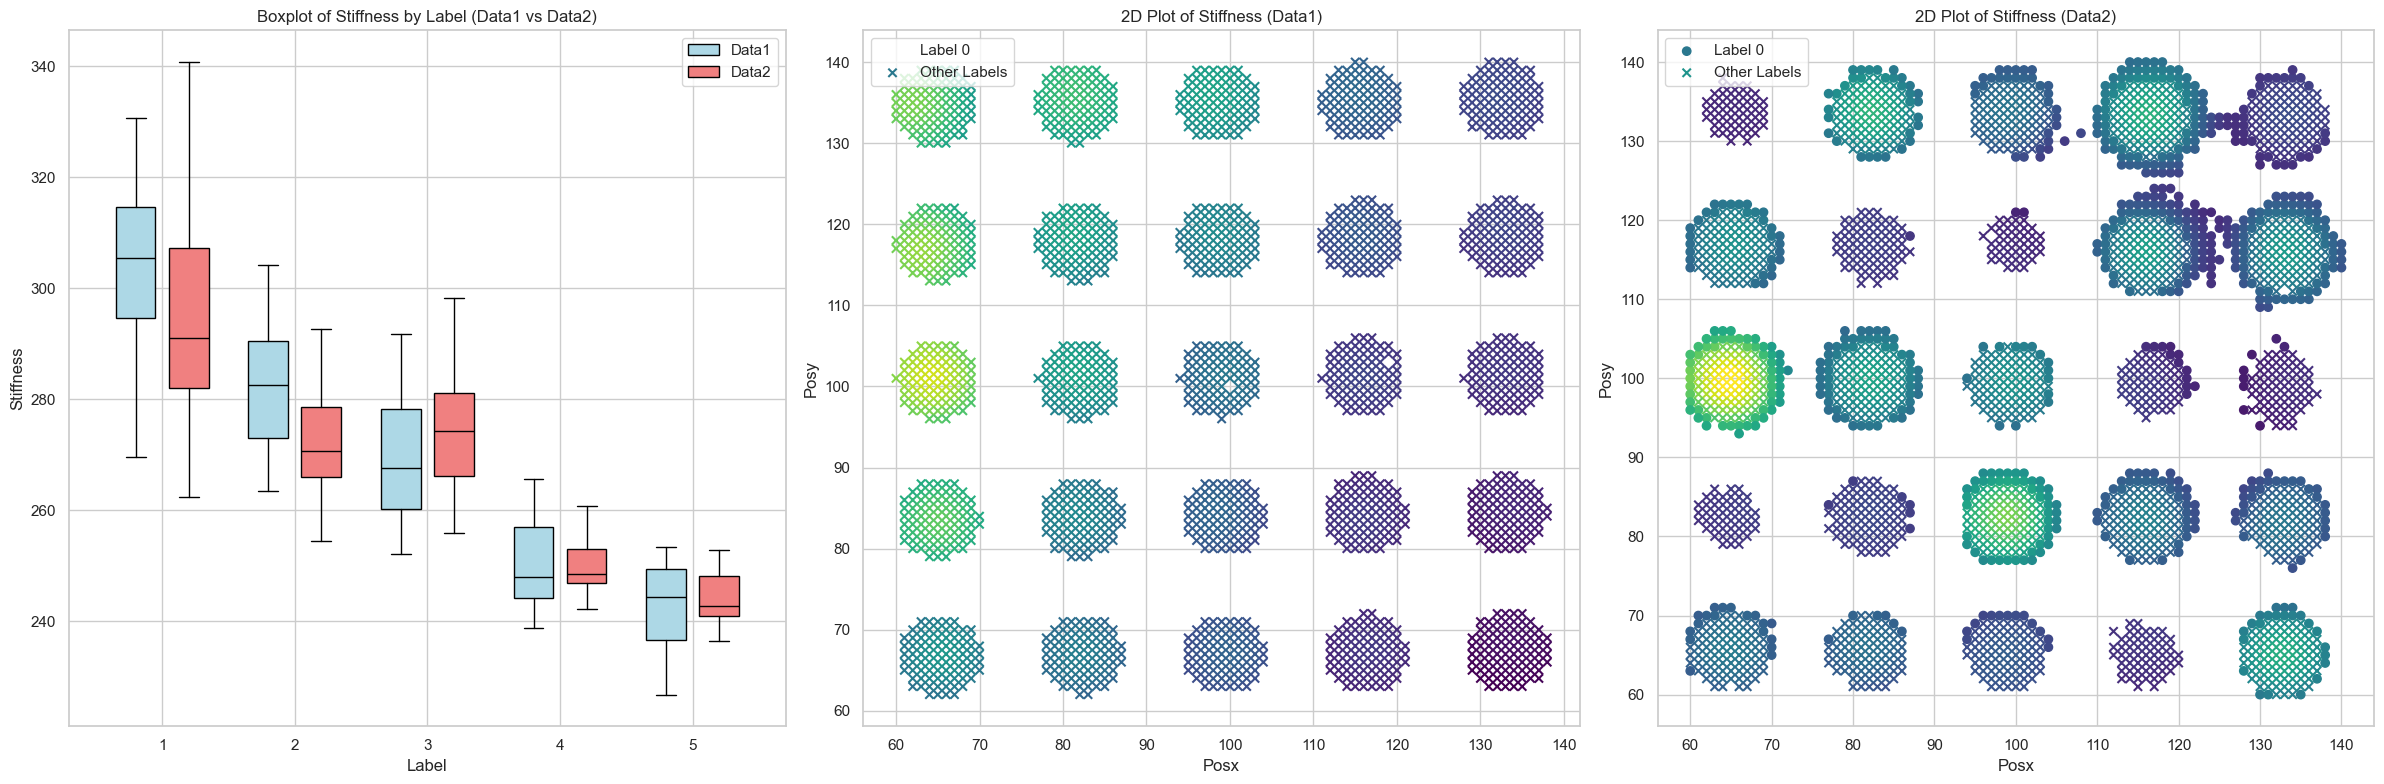

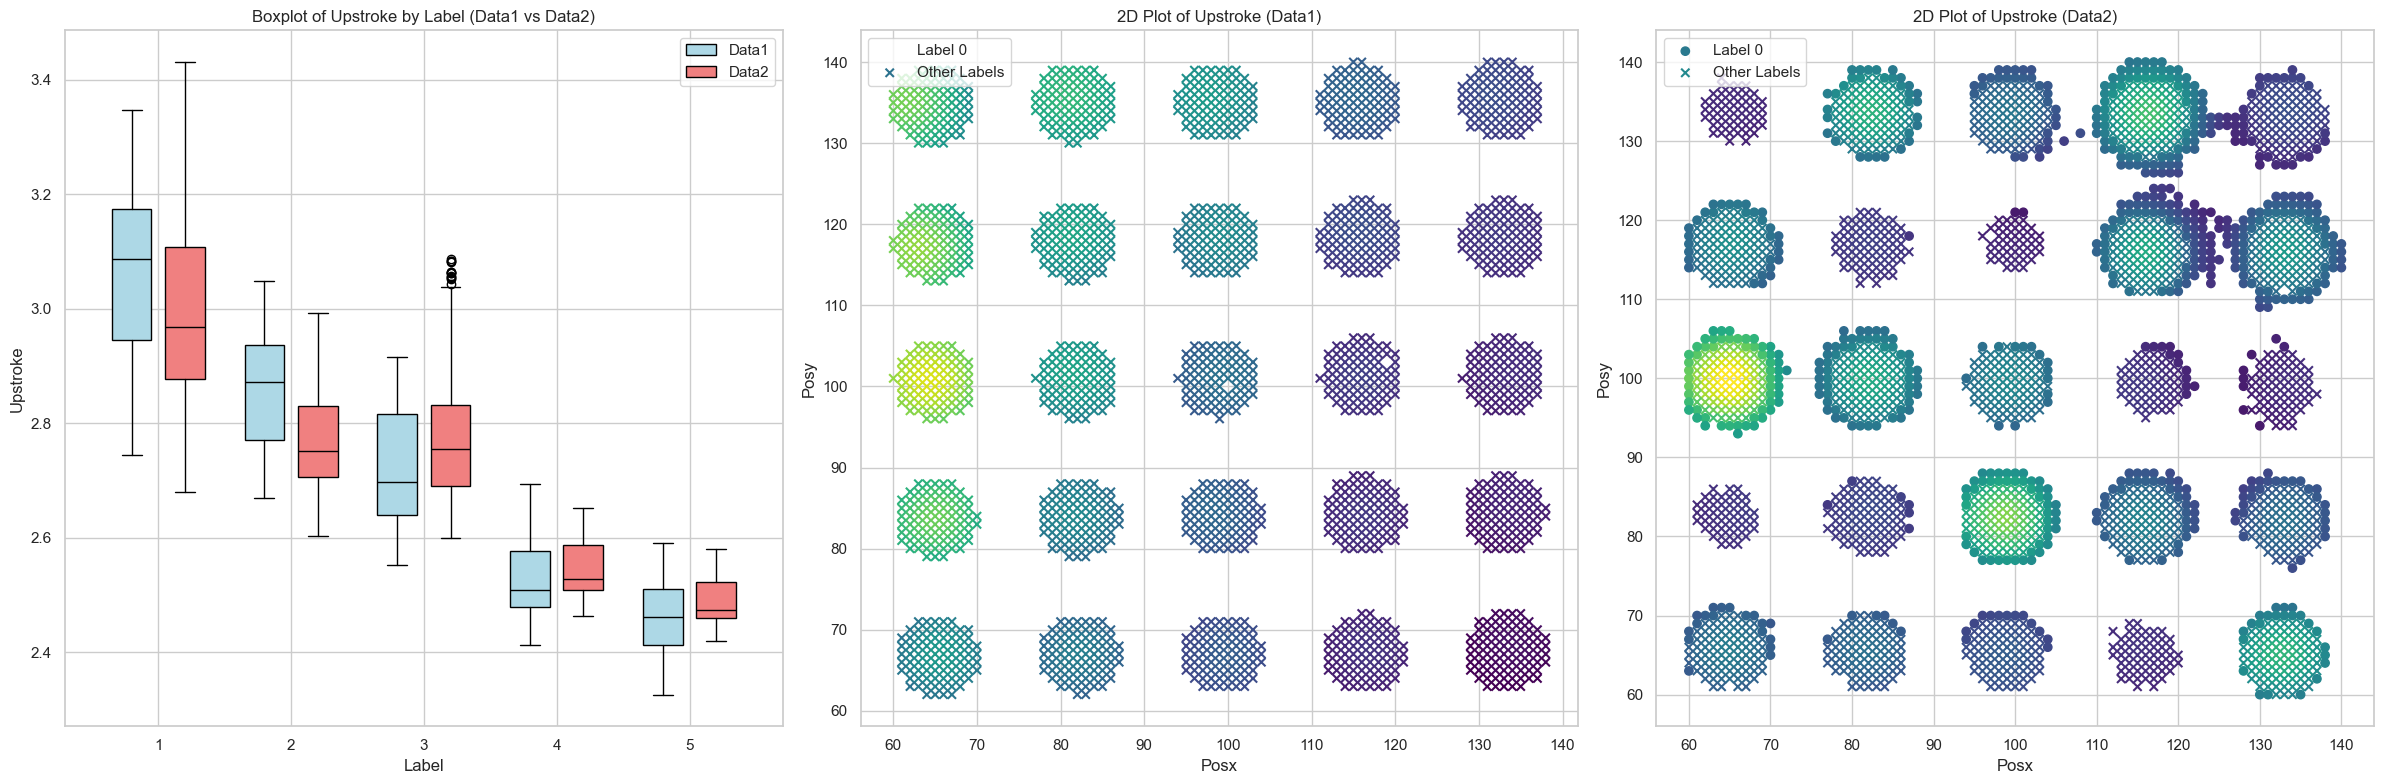

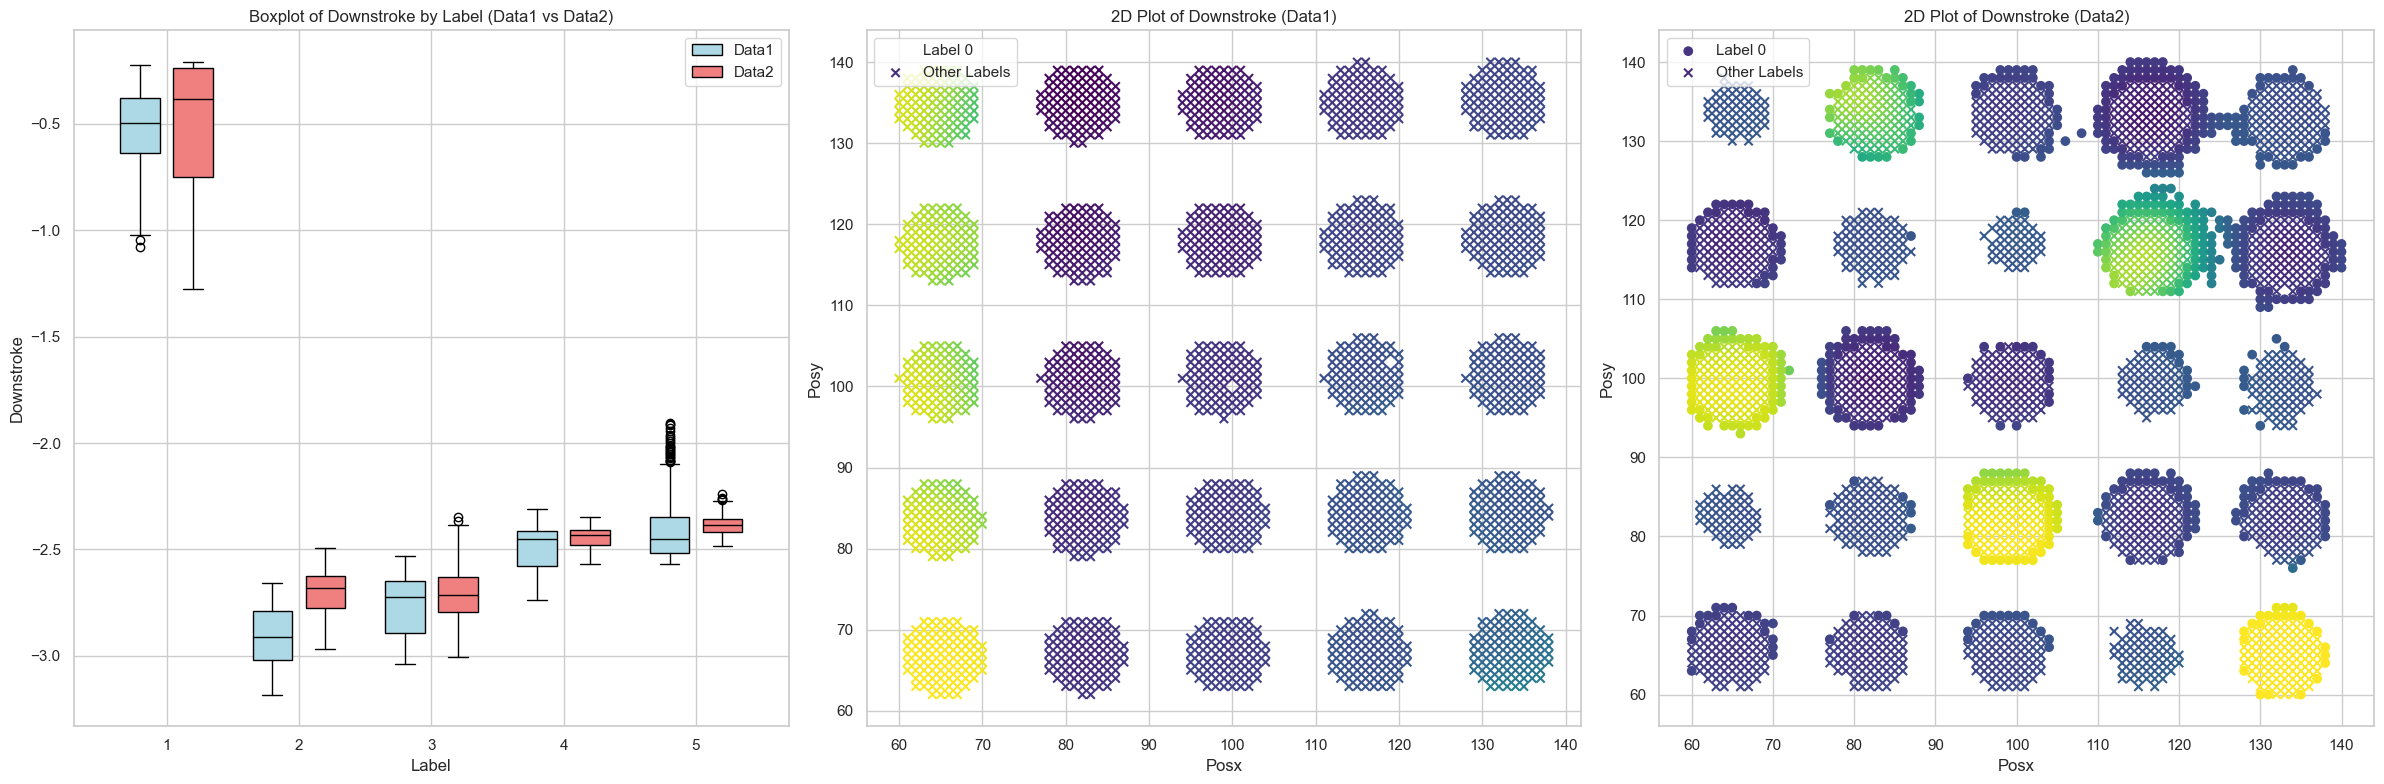

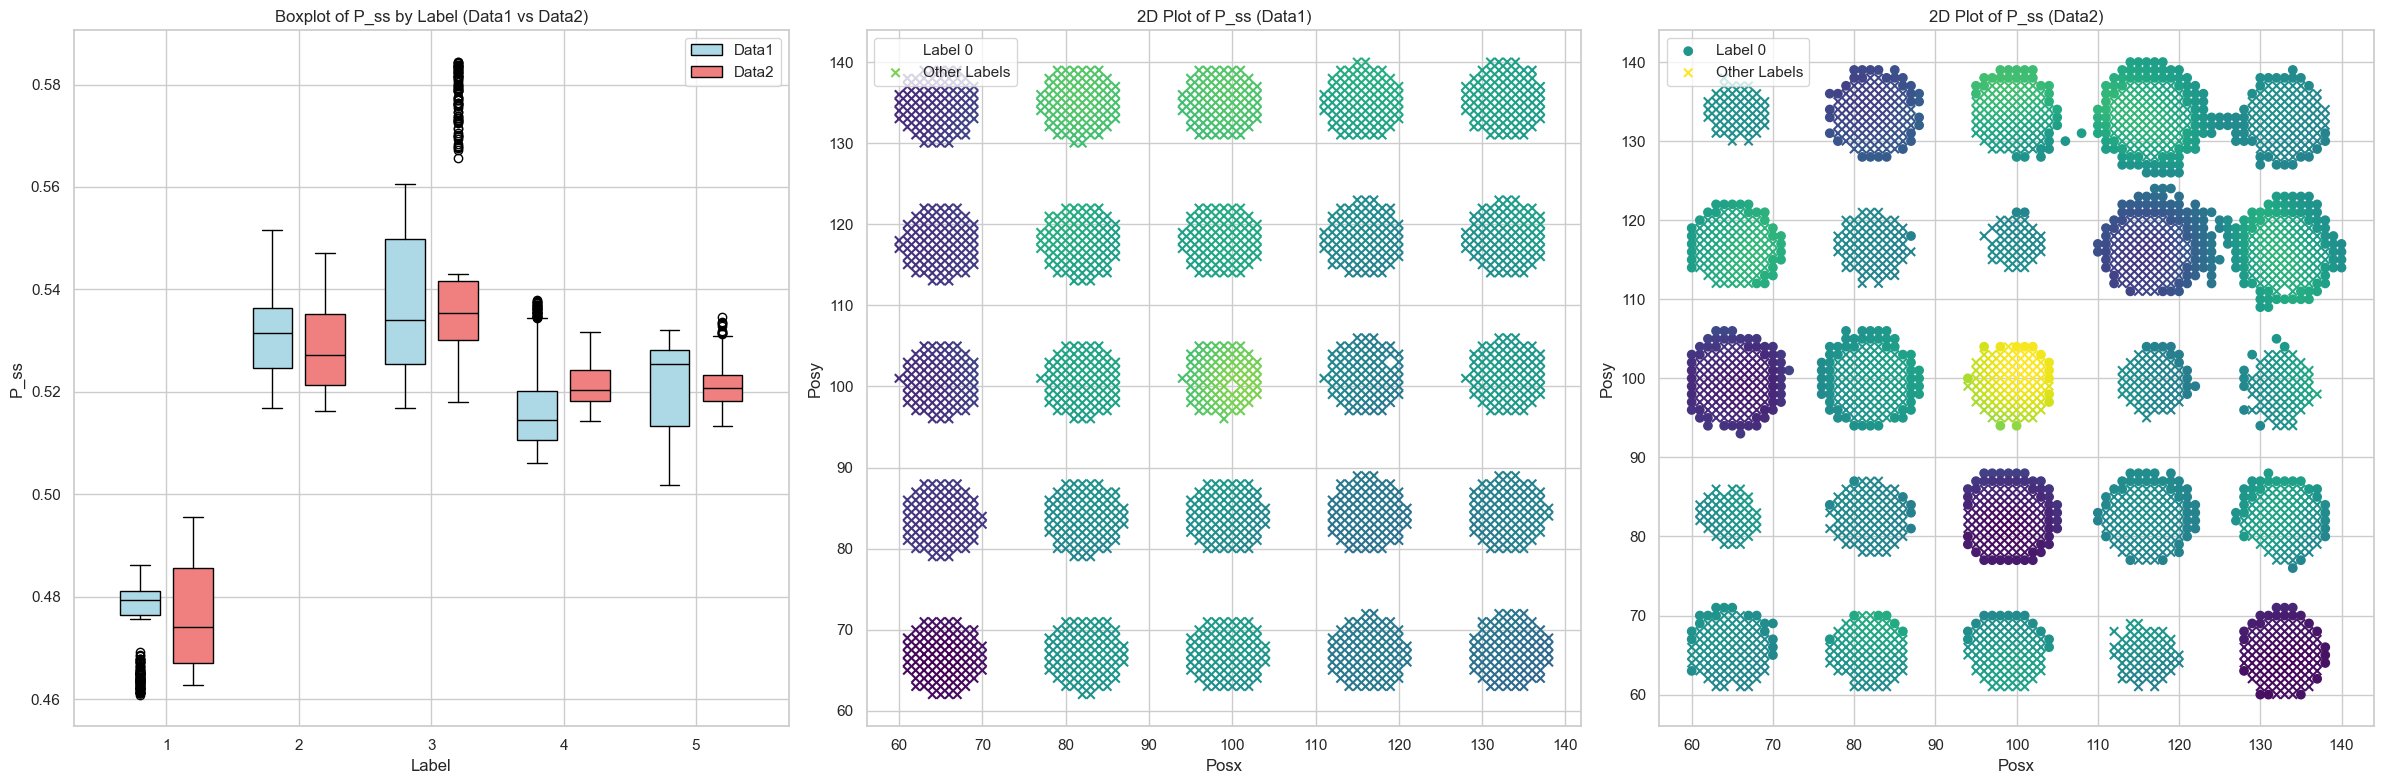

NameError: name 'X_train_nz' is not defined

In [43]:
from plotter import plot_features

hard_spots_test["label"] = y_test_hard
hard_spots_train["label"] = y_train_hard

hard_spots_test_smoothed = hard_spots_test_smoothed.copy()
hard_spots_test_smoothed["label"] = y_test_hard

hard_spots_train_smoothed = hard_spots_train_smoothed.copy()
hard_spots_train_smoothed["label"] = y_train_hard

# Call function with datasets
plot_features(hard_spots_train_smoothed, hard_spots_test_smoothed, feature_list)
print("\n\n")
X_train_nz = X_train_nz.copy()
X_train_nz["label"] = y_train_nz

X_test_new_nz = X_test_new_nz.copy()
X_test_new_nz["label"] = y_test_nz

plot_features(X_train_nz, X_test_new_nz, feature_list)



Training XGBoost...


C:\Users\brill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


XGBoost Training Accuracy: 0.0000
XGBoost Training Balanced Accuracy: 0.0000
XGBoost Test Accuracy: 0.2102
XGBoost Test Balanced Accuracy: 0.1917


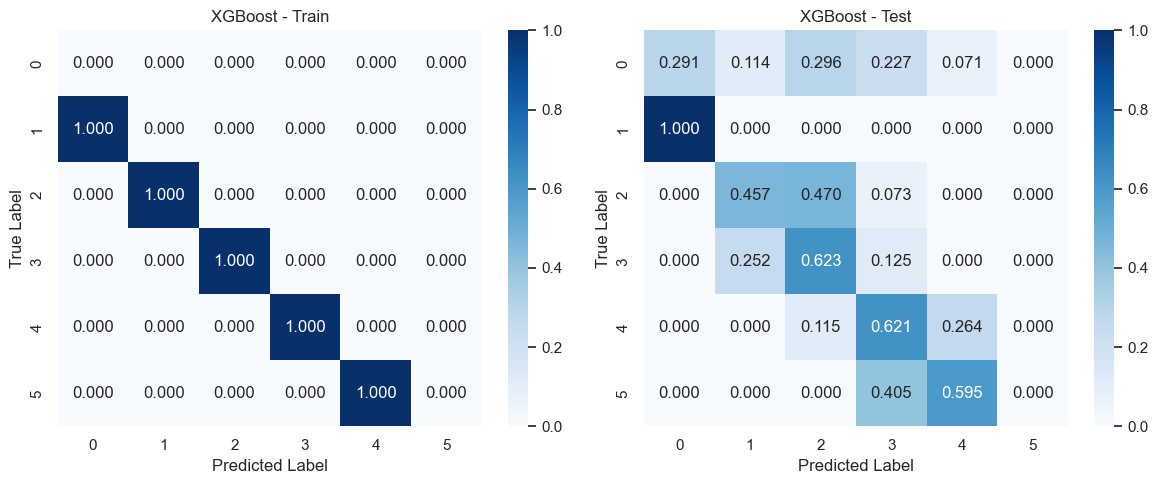

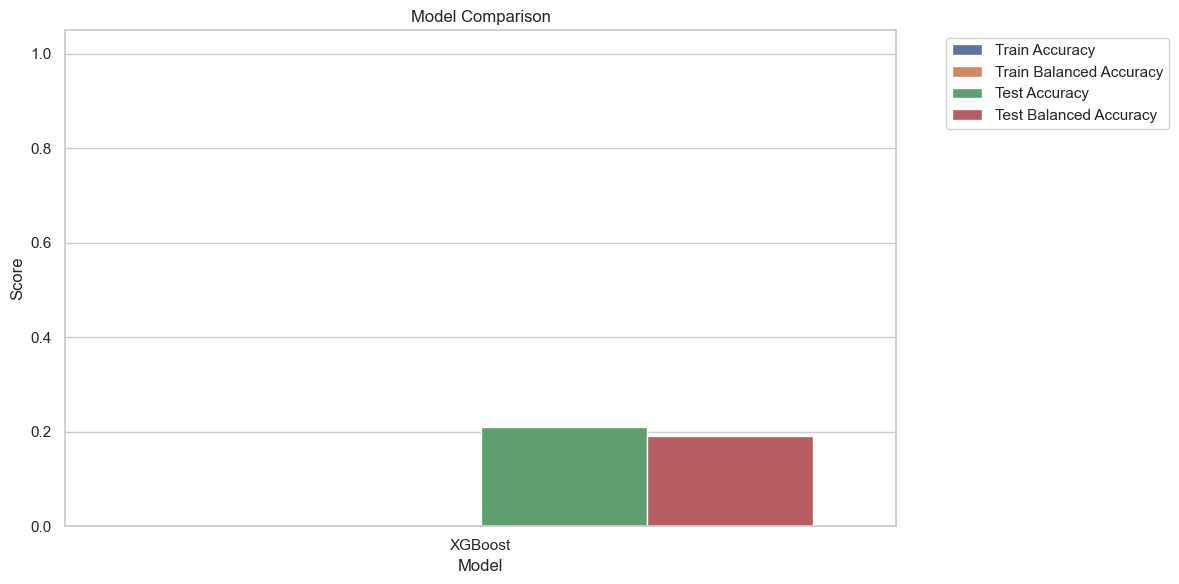

In [49]:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
#
# from xgboost import XGBClassifier
#
#
#
# # Define models in a list of tuples (name, model instance)
# models = [
#     # ('SVM', SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42)),  # n_jobs not supported
#     # ('KNN', KNeighborsClassifier(n_neighbors=8, metric='minkowski', p=2, n_jobs=-1)),
#     # ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)),
#     # ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
#     # ('Naive Bayes', GaussianNB()),  # no n_jobs
#     ('XGBoost', XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', n_jobs=-1, random_state=42))
# ]
#
#
# def fit_and_evaluate_models(models, X_train, y_train, X_test, y_test):
#     results = []
#
#     for i, (name, model) in enumerate(models):
#         print(f"\nTraining {name}...")
#         model.fit(X_train, y_train - 1  )
#
#         y_train_pred = model.predict(X_train)
#         y_test_pred = model.predict(X_test)
#
#         # Evaluation metrics
#         train_acc = accuracy_score(y_train, y_train_pred)
#         test_acc = accuracy_score(y_test, y_test_pred)
#         train_bal_acc = balanced_accuracy_score(y_train, y_train_pred)
#         test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
#
#         print(f"{name} Training Accuracy: {train_acc:.4f}")
#         print(f"{name} Training Balanced Accuracy: {train_bal_acc:.4f}")
#         print(f"{name} Test Accuracy: {test_acc:.4f}")
#         print(f"{name} Test Balanced Accuracy: {test_bal_acc:.4f}")
#
#         results.append({
#             'Model': name,
#             'Train Accuracy': train_acc,
#             'Train Balanced Accuracy': train_bal_acc,
#             'Test Accuracy': test_acc,
#             'Test Balanced Accuracy': test_bal_acc
#         })
#
#         # Plot for this model
#         fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#         plot_confusion_matrix(y_train, y_train_pred, f'{name} - Train', axes[0])
#         plot_confusion_matrix(y_test, y_test_pred, f'{name} - Test', axes[1])
#         plt.tight_layout()
#         plt.show()
#
#     return results
#
#
# # X_train_selected = hard_spots_train_smoothed[feature_list]
# # X_test_selected = hard_spots_test_smoothed[feature_list]
# # y_train_nz = y_train_hard
# # y_test_nz = y_test_hard
# # X_train_adasyn, y_train_adasyn = X_train_selected, y_train_nz
#
# # Example call
# results = fit_and_evaluate_models(models, X_train_adasyn, y_train_adasyn, X_test_selected, y_test_nz)
#
#
# # Plot comparison bar chart
# def plot_model_comparison(results):
#     import pandas as pd
#     import seaborn as sns
#
#     df = pd.DataFrame(results)
#     df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')
#
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
#     plt.title('Model Comparison')
#     plt.ylim(0, 1.05)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.show()
#
#
# plot_model_comparison(results)
